## 1. Importación de librerías y configuración inicial


In [12]:
%pip uninstall -y nbformat
%pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ===== IMPORTACIÓN DE LIBRERÍAS =====

# Instalar dependencias necesarias

# Librerías básicas
import pandas as pd
import numpy as np
import os
import warnings
import yaml
import pickle
import json
from datetime import datetime
import logging
warnings.filterwarnings('ignore')

# Librerías para procesamiento de imágenes
from skimage import io, color, feature, measure, filters, segmentation
from skimage.transform import resize
import cv2

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librerías para balance de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight

# Librerías para reducción de dimensionalidad y selección de características
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import (SelectKBest, f_classif, chi2, mutual_info_classif,
                                     RFECV, SelectFromModel, VarianceThreshold)

# Librerías para modelos de machine learning
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, 
                                   StratifiedKFold, cross_val_score, validation_curve)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, StackingClassifier,
                            GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Librerías para evaluación de modelos
from sklearn.metrics import (classification_report, accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, matthews_corrcoef, cohen_kappa_score)

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para medición de rendimiento
import time
import psutil
from memory_profiler import profile
import gc

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ===== CONFIGURACIÓN CENTRALIZADA =====
# Actualizar rutas en CONFIG['paths']

CONFIG = {
    'paths': {
    'metadata_file': r"C:\Users\torre\Downloads\PAD_UFES_Extractor\metadata.csv",
    'images_folder': r"C:\Users\torre\Downloads\PAD_UFES_Extractor\data\images",
    'output_folder': r"C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados",
    'models_folder': r"C:\Users\torre\Downloads\PAD_UFES_Extractor\modelos",
    'plots_folder': r"C:\Users\torre\Downloads\PAD_UFES_Extractor\graficos"
},

    
    'data_params': {
        'test_size': 0.25,
        'val_size': 0.15,
        'random_state': 42,
        'target_image_size': (224, 224)
    },
    
    'preprocessing': {
        'handle_missing_values': True,
        'missing_threshold': 0.5,  # Eliminar columnas con >50% valores faltantes
        'imputation_strategy': {
            'numeric': 'median',  # 'mean', 'median', 'knn'
            'categorical': 'most_frequent'  # 'most_frequent', 'constant'
        },
        'scaling_method': 'standard'  # 'standard', 'robust', 'minmax'
    },
    
    'feature_extraction': {
        'extract_color_features': True,
        'extract_texture_features': True,
        'extract_shape_features': True,
        'extract_statistical_features': True,
        'color_bins': 20,
        'glcm_distances': [1, 2, 3],
        'glcm_angles': [0, 45, 90, 135],
        'lbp_radius': 3,
        'lbp_n_points': 24
    },
    
    'dimensionality_reduction': {
        'apply_pca': True,
        'pca_variance_threshold': 0.95,
        'apply_feature_selection': True,
        'feature_selection_method': 'univariate',  # 'univariate', 'rfe', 'importance'
        'n_features_to_select': 50
    },
    
    'class_balance': {
        'apply_smote': True,
        'smote_method': 'SMOTE',  # 'SMOTE', 'ADASYN', 'BorderlineSMOTE'
        'smote_k_neighbors': 5,
        'use_class_weights': True,
        'undersampling': False
    },
    
    'model_params': {
        'cv_folds': 5,
        'n_jobs': -1,
        'max_iter': 1000,
        'scoring_metric': 'f1_weighted',
        'hyperparameter_search': 'randomized',  # 'grid', 'randomized'
        'n_iter_search': 100
    },
    
    'ensemble_params': {
        'voting_types': ['hard', 'soft'],
        'auto_weights': True,
        'stacking_final_estimator': 'logistic',  # 'logistic', 'gradient_boosting'
        'stacking_cv': 5
    },
    
    'evaluation': {
        'metrics': ['accuracy', 'precision', 'recall', 'f1', 'auc', 'kappa'],
        'plot_confusion_matrix': True,
        'plot_roc_curves': True,
        'plot_precision_recall': True,
        'save_predictions': True
    },
    
    'visualization': {
        'save_plots': True,
        'plot_format': 'png',
        'dpi': 300,
        'interactive_plots': True,
        'plot_style': 'seaborn-v0_8'
    },
    
    'logging': {
        'level': 'INFO',
        'save_logs': True,
        'log_file': 'multimodal_analysis.log'
    }
}

# ===== FUNCIONES DE CONFIGURACIÓN =====

def create_directories(config):
    """Crea directorios necesarios para el proyecto"""
    directories = [
        config['paths']['output_folder'],
        config['paths']['models_folder'],
        config['paths']['plots_folder']
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    print("Directorios creados:")
    for directory in directories:
        print(f"  ✓ {directory}")

def setup_logging(config):
    """Configura el sistema de logging"""
    if config['logging']['save_logs']:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(config['logging']['log_file']),
                logging.StreamHandler()
            ]
        )
    else:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
    
    return logging.getLogger(__name__)

def save_config(config, filepath='config.yaml'):
    """Guarda la configuración en un archivo YAML"""
    with open(filepath, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, indent=2)
    print(f"Configuración guardada en: {filepath}")

def load_config(filepath='config.yaml'):
    """Carga la configuración desde un archivo YAML"""
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            loaded_config = yaml.safe_load(f)
        print(f"Configuración cargada desde: {filepath}")
        return loaded_config
    else:
        print("Archivo de configuración no encontrado. Usando configuración por defecto.")
        return CONFIG

def print_config_summary(config):
    """Imprime un resumen de la configuración"""
    print("="*60)
    print("RESUMEN DE CONFIGURACIÓN")
    print("="*60)
    
    print(f"📁 Archivos:")
    print(f"  Metadata: {config['paths']['metadata_file']}")
    print(f"  Imágenes: {config['paths']['images_folder']}")
    print(f"  Resultados: {config['paths']['output_folder']}")
    
    print(f"\n📊 División de datos:")
    print(f"  Test: {config['data_params']['test_size']*100:.1f}%")
    print(f"  Validación: {config['data_params']['val_size']*100:.1f}%")
    print(f"  Entrenamiento: {(1-config['data_params']['test_size']-config['data_params']['val_size'])*100:.1f}%")
    
    print(f"\n🔧 Preprocesamiento:")
    print(f"  Balance de clases: {'✓' if config['class_balance']['apply_smote'] else '✗'}")
    print(f"  PCA: {'✓' if config['dimensionality_reduction']['apply_pca'] else '✗'}")
    print(f"  Selección de características: {'✓' if config['dimensionality_reduction']['apply_feature_selection'] else '✗'}")
    
    print(f"\n🤖 Modelos:")
    print(f"  Validación cruzada: {config['model_params']['cv_folds']} folds")
    print(f"  Búsqueda de hiperparámetros: {config['model_params']['hyperparameter_search']}")
    print(f"  Métrica de evaluación: {config['model_params']['scoring_metric']}")

# ===== INICIALIZACIÓN =====

# Crear directorios
create_directories(CONFIG)

# Configurar logging
logger = setup_logging(CONFIG)

# Guardar configuración inicial
save_config(CONFIG)

# Mostrar resumen de configuración
print_config_summary(CONFIG)

print("\n" + "="*60)
print("INICIALIZACIÓN COMPLETADA")
print("="*60)
print(f"Fecha y hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Configuración guardada en: config.yaml")
print(f"Logs guardados en: {CONFIG['logging']['log_file']}")

Directorios creados:
  ✓ C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados
  ✓ C:\Users\torre\Downloads\PAD_UFES_Extractor\modelos
  ✓ C:\Users\torre\Downloads\PAD_UFES_Extractor\graficos
Configuración guardada en: config.yaml
RESUMEN DE CONFIGURACIÓN
📁 Archivos:
  Metadata: C:\Users\torre\Downloads\PAD_UFES_Extractor\metadata.csv
  Imágenes: C:\Users\torre\Downloads\PAD_UFES_Extractor\data\images
  Resultados: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados

📊 División de datos:
  Test: 25.0%
  Validación: 15.0%
  Entrenamiento: 60.0%

🔧 Preprocesamiento:
  Balance de clases: ✓
  PCA: ✓
  Selección de características: ✓

🤖 Modelos:
  Validación cruzada: 5 folds
  Búsqueda de hiperparámetros: randomized
  Métrica de evaluación: f1_weighted

INICIALIZACIÓN COMPLETADA
Fecha y hora: 2025-06-15 02:25:13
Configuración guardada en: config.yaml
Logs guardados en: multimodal_analysis.log


## 2. Carga y exploración inicial del dataset con visualizaciones avanzadas


INFO:__main__:Iniciando carga del dataset
INFO:__main__:Dataset cargado exitosamente: (2298, 26)


CARGA Y EXPLORACIÓN DEL DATASET
✓ Dataset cargado: 2298 filas, 26 columnas

📋 Información básica del dataset:
  Forma: (2298, 26)
  Memoria utilizada: 2.14 MB
  Tipos de datos:
    object: 20 columnas
    float64: 3 columnas
    int64: 2 columnas
    bool: 1 columnas

📊 Análisis de columnas:
  Columnas disponibles: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']
  Columnas ID: ['patient_id', 'lesion_id', 'img_id']
  Columna objetivo: diagnostic
  Columnas numéricas: ['age', 'fitspatrick', 'diameter_1', 'diameter_2']
  Columnas categóricas: ['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_sy

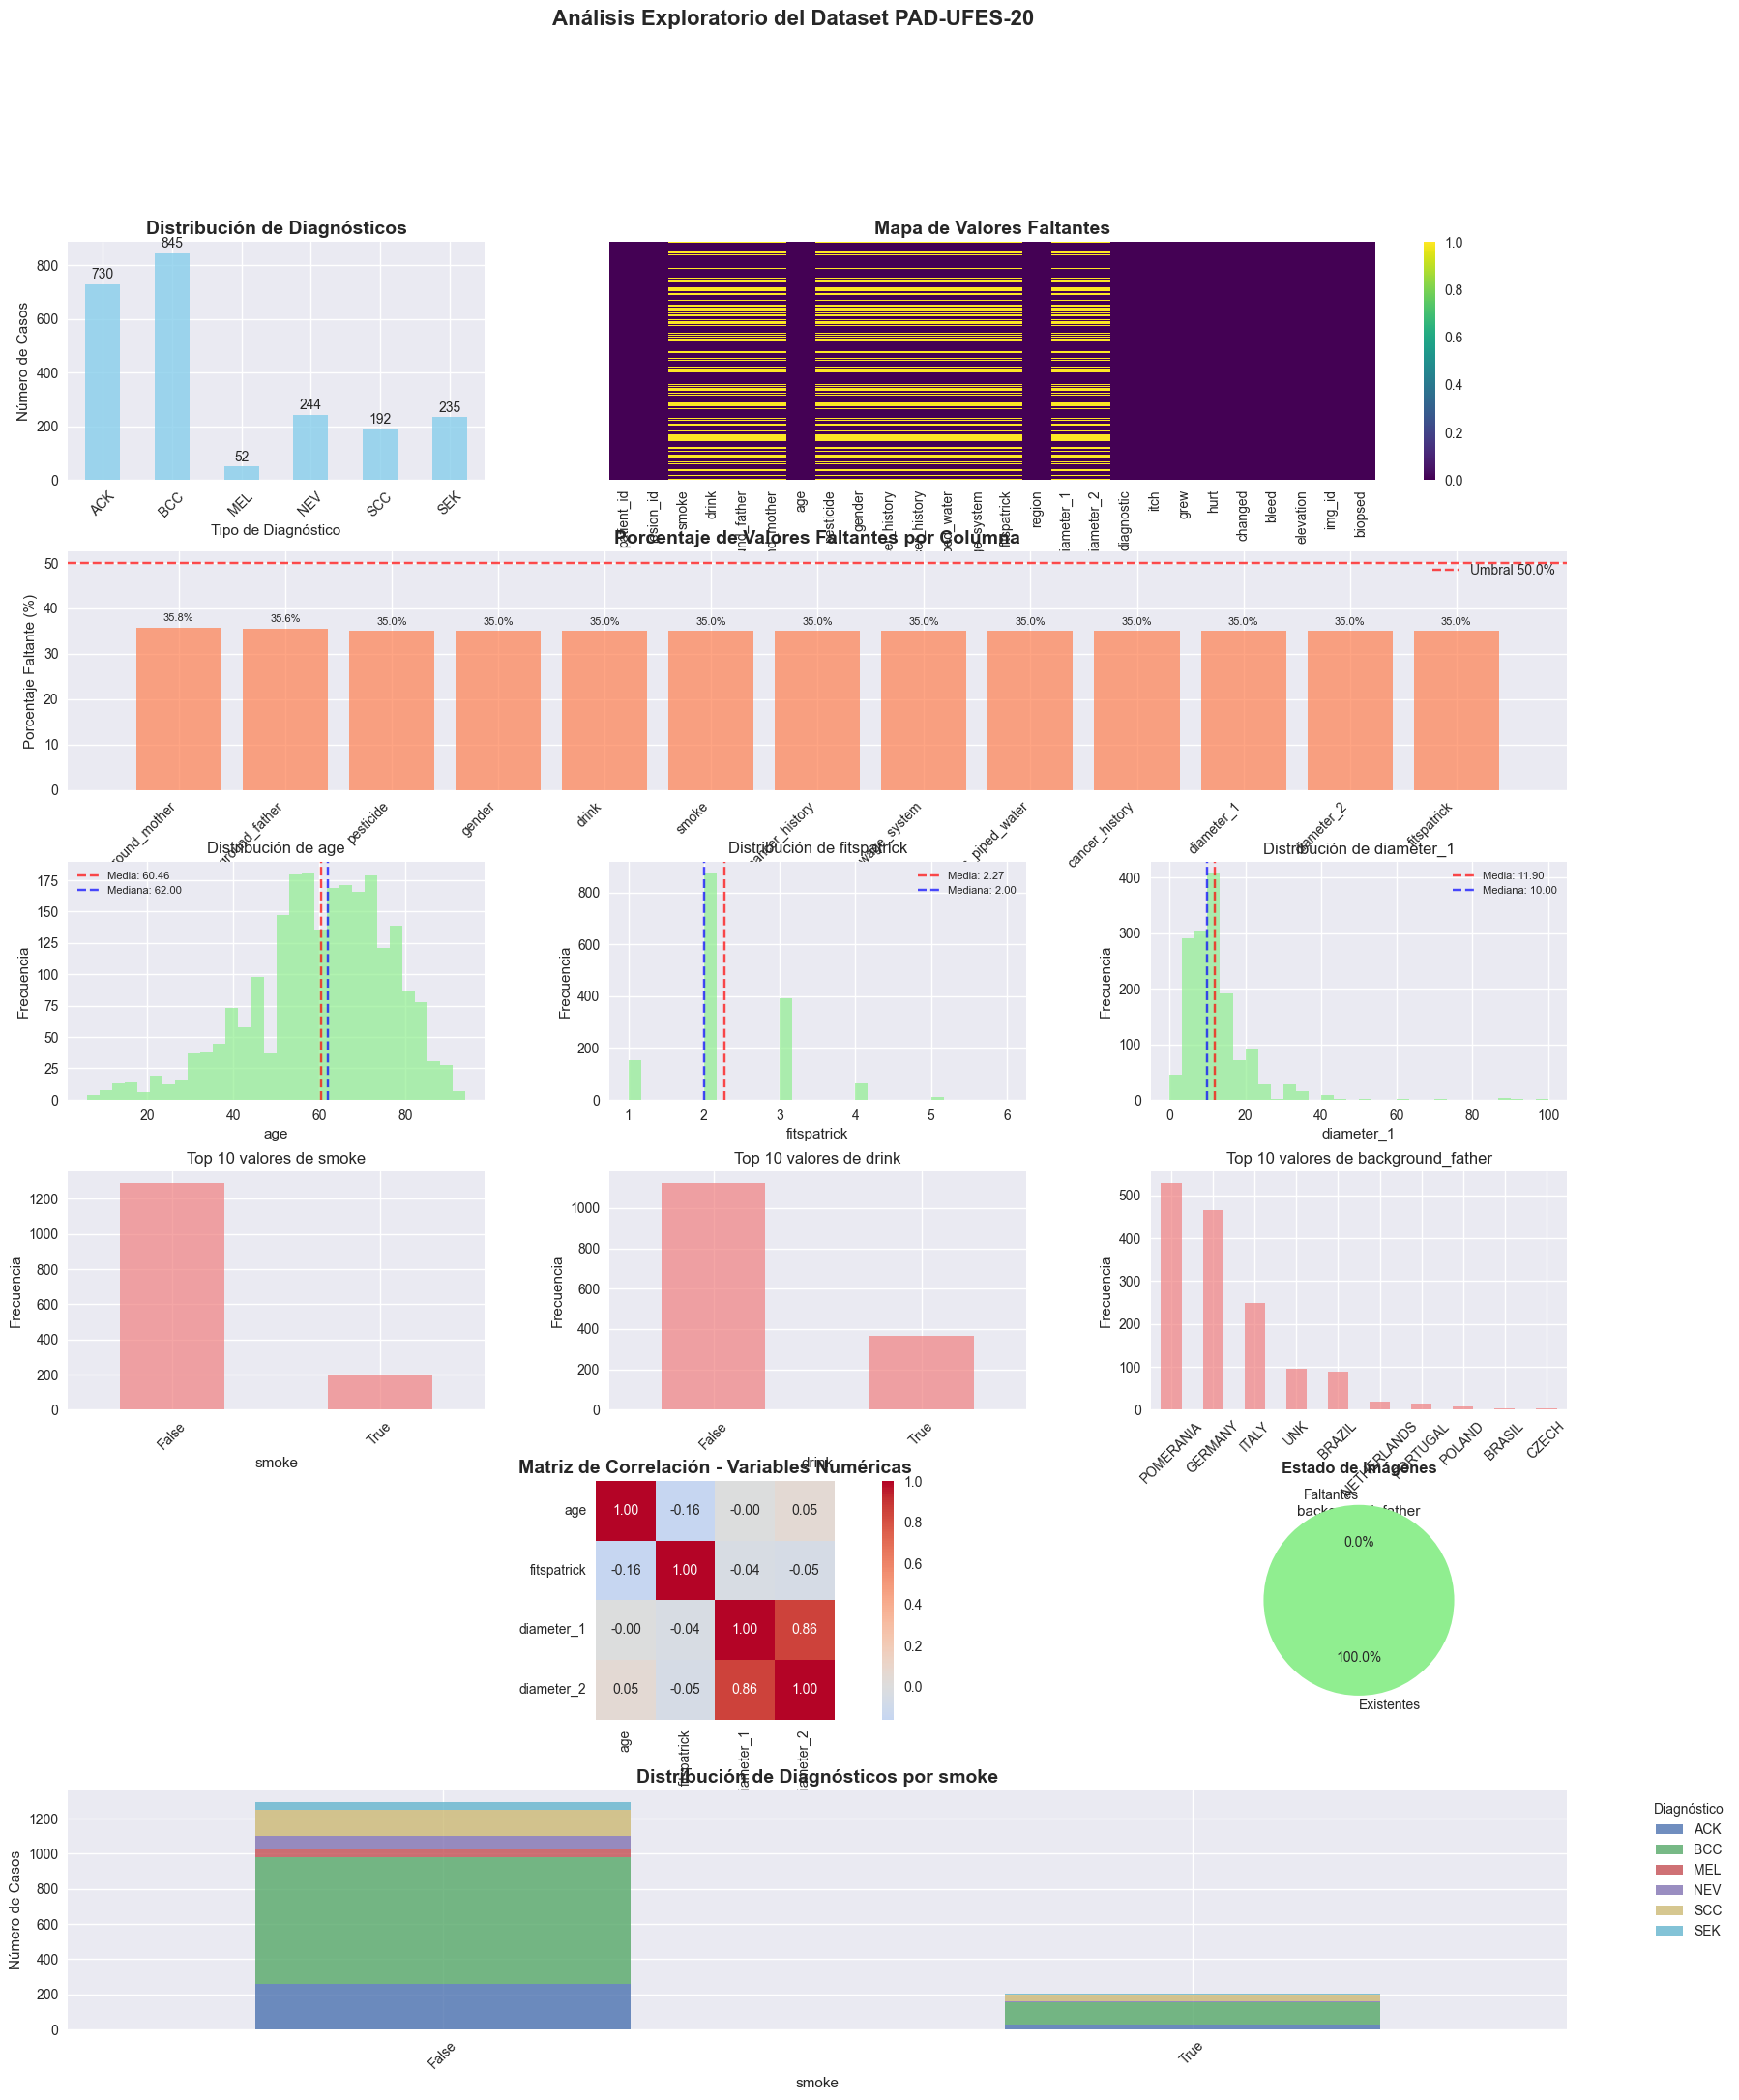


📊 Generando visualizaciones interactivas...
✓ Gráfico interactivo guardado en: C:\Users\torre\Downloads\PAD_UFES_Extractor\graficos\interactive_class_distribution.html


INFO:__main__:Exploración del dataset completada exitosamente



✓ Resultados de exploración guardados en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\exploration_results.json


In [3]:
def load_and_explore_dataset(config):
    """
    Carga y realiza exploración exhaustiva del dataset PAD-UFES-20
    
    Args:
        config: Configuración del proyecto
    
    Returns:
        df: DataFrame cargado
        exploration_results: Resultados de la exploración
    """
    
    print("="*60)
    print("CARGA Y EXPLORACIÓN DEL DATASET")
    print("="*60)
    
    logger.info("Iniciando carga del dataset")
    
    # ===== CARGA DEL DATASET =====
    try:
        df = pd.read_csv(config['paths']['metadata_file'])
        logger.info(f"Dataset cargado exitosamente: {df.shape}")
        print(f"✓ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    except Exception as e:
        logger.error(f"Error al cargar el dataset: {e}")
        raise
    
    # ===== INFORMACIÓN BÁSICA =====
    print(f"\n📋 Información básica del dataset:")
    print(f"  Forma: {df.shape}")
    print(f"  Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Tipos de datos:")
    for dtype in df.dtypes.value_counts().items():
        print(f"    {dtype[0]}: {dtype[1]} columnas")
    
    # ===== ANÁLISIS DE COLUMNAS =====
    print(f"\n📊 Análisis de columnas:")
    print(f"  Columnas disponibles: {list(df.columns)}")
    
    # Identificar tipos de columnas
    id_columns = ['patient_id', 'lesion_id', 'img_id']
    target_column = 'diagnostic'
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remover columnas de ID y target de las listas
    numeric_columns = [col for col in numeric_columns if col not in id_columns + [target_column]]
    categorical_columns = [col for col in categorical_columns if col not in id_columns + [target_column]]
    
    print(f"  Columnas ID: {id_columns}")
    print(f"  Columna objetivo: {target_column}")
    print(f"  Columnas numéricas: {numeric_columns}")
    print(f"  Columnas categóricas: {categorical_columns}")
    
    # ===== ANÁLISIS DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis de valores faltantes:")
    
    missing_analysis = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Faltantes': df.isnull().sum(),
        'Porcentaje_Faltante': (df.isnull().sum() / len(df)) * 100,
        'Tipo_Dato': df.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis)
    
    # Identificar columnas con muchos valores faltantes
    high_missing_cols = missing_analysis[
        missing_analysis['Porcentaje_Faltante'] > config['preprocessing']['missing_threshold'] * 100
    ]['Columna'].tolist()
    
    if high_missing_cols:
        print(f"\n⚠️  Columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        for col in high_missing_cols:
            pct = missing_analysis[missing_analysis['Columna'] == col]['Porcentaje_Faltante'].iloc[0]
            print(f"    {col}: {pct:.1f}%")
    
    # ===== ANÁLISIS DE LA VARIABLE OBJETIVO =====
    print(f"\n🎯 Análisis de la variable objetivo '{target_column}':")
    
    target_analysis = df[target_column].value_counts().sort_index()
    target_percentages = (target_analysis / len(df)) * 100
    
    print("Distribución de clases:")
    for class_name, count in target_analysis.items():
        percentage = target_percentages[class_name]
        print(f"  {class_name}: {count} casos ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = target_analysis.max()
    min_class_size = target_analysis.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"\nMétricas de desbalance:")
    print(f"  Clase mayoritaria: {target_analysis.idxmax()} ({max_class_size} casos)")
    print(f"  Clase minoritaria: {target_analysis.idxmin()} ({min_class_size} casos)")
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 5:
        print("  ⚠️  Dataset significativamente desbalanceado (ratio > 5:1)")
    elif imbalance_ratio > 2:
        print("  ⚠️  Dataset moderadamente desbalanceado (ratio > 2:1)")
    else:
        print("  ✓ Dataset relativamente balanceado")
    
    # ===== ANÁLISIS ESTADÍSTICO DE VARIABLES NUMÉRICAS =====
    if numeric_columns:
        print(f"\n📈 Estadísticas descriptivas de variables numéricas:")
        numeric_stats = df[numeric_columns].describe()
        print(numeric_stats)
        
        # Detectar outliers usando IQR
        print(f"\n🔍 Detección de outliers (método IQR):")
        outlier_summary = {}
        for col in numeric_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(df)) * 100
            
            outlier_summary[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"  {col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")
    
    # ===== ANÁLISIS DE VARIABLES CATEGÓRICAS =====
    if categorical_columns:
        print(f"\n📊 Análisis de variables categóricas:")
        categorical_summary = {}
        
        for col in categorical_columns:
            unique_values = df[col].nunique()
            most_frequent = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
            most_frequent_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            most_frequent_pct = (most_frequent_count / len(df)) * 100
            
            categorical_summary[col] = {
                'unique_values': unique_values,
                'most_frequent': most_frequent,
                'most_frequent_count': most_frequent_count,
                'most_frequent_percentage': most_frequent_pct
            }
            
            print(f"  {col}:")
            print(f"    Valores únicos: {unique_values}")
            print(f"    Más frecuente: '{most_frequent}' ({most_frequent_count} casos, {most_frequent_pct:.1f}%)")
            
            # Mostrar distribución si hay pocos valores únicos
            if unique_values <= 10:
                value_counts = df[col].value_counts()
                print(f"    Distribución: {dict(value_counts)}")
    
    # ===== VERIFICACIÓN DE IMÁGENES =====
    print(f"\n🖼️  Verificación de imágenes:")
    
    if 'img_id' in df.columns:
        total_images_metadata = len(df)
        
        # Verificar cuántas imágenes existen físicamente
        images_folder = config['paths']['images_folder']
        if os.path.exists(images_folder):
            existing_images = []
            missing_images = []
            
            print("Verificando existencia de archivos de imagen...")
            for idx, img_id in enumerate(df['img_id']):
                img_path = os.path.join(images_folder, img_id)
                if os.path.exists(img_path):
                    existing_images.append(img_id)
                else:
                    missing_images.append(img_id)
                
                # Mostrar progreso cada 500 imágenes
                if (idx + 1) % 500 == 0:
                    print(f"  Verificadas: {idx + 1}/{total_images_metadata}")
            
            print(f"\nResultados de verificación:")
            print(f"  Imágenes en metadata: {total_images_metadata}")
            print(f"  Imágenes existentes: {len(existing_images)} ({len(existing_images)/total_images_metadata*100:.1f}%)")
            print(f"  Imágenes faltantes: {len(missing_images)} ({len(missing_images)/total_images_metadata*100:.1f}%)")
            
            if missing_images:
                print(f"  ⚠️  Primeras 5 imágenes faltantes: {missing_images[:5]}")
        else:
            print(f"  ⚠️  Carpeta de imágenes no encontrada: {images_folder}")
            existing_images = []
            missing_images = list(df['img_id'])
    else:
        print("  ⚠️  Columna 'img_id' no encontrada en el dataset")
        existing_images = []
        missing_images = []
    
    # ===== CREAR VISUALIZACIONES AVANZADAS =====
    print(f"\n📊 Generando visualizaciones...")
    
    # Configurar el estilo de las visualizaciones
    plt.style.use(config['visualization']['plot_style'])
    
    # Crear figura principal con múltiples subplots
    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(6, 3, hspace=0.3, wspace=0.3)
    
    # 1. Distribución de clases
    ax1 = fig.add_subplot(gs[0, 0])
    target_analysis.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('Distribución de Diagnósticos', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Diagnóstico')
    ax1.set_ylabel('Número de Casos')
    ax1.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for i, v in enumerate(target_analysis.values):
        ax1.text(i, v + max(target_analysis.values)*0.01, str(v), ha='center', va='bottom')
    
    # 2. Mapa de calor de valores faltantes
    ax2 = fig.add_subplot(gs[0, 1:])
    missing_matrix = df.isnull()
    sns.heatmap(missing_matrix, cbar=True, yticklabels=False, cmap='viridis', ax=ax2)
    ax2.set_title('Mapa de Valores Faltantes', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Columnas')
    
    # 3. Porcentaje de valores faltantes por columna
    ax3 = fig.add_subplot(gs[1, :])
    missing_pct = missing_analysis[missing_analysis['Porcentaje_Faltante'] > 0]
    if not missing_pct.empty:
        bars = ax3.bar(range(len(missing_pct)), missing_pct['Porcentaje_Faltante'], 
                      color='coral', alpha=0.7)
        ax3.set_title('Porcentaje de Valores Faltantes por Columna', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Columnas')
        ax3.set_ylabel('Porcentaje Faltante (%)')
        ax3.set_xticks(range(len(missing_pct)))
        ax3.set_xticklabels(missing_pct['Columna'], rotation=45, ha='right')
        
        # Línea de umbral
        ax3.axhline(y=config['preprocessing']['missing_threshold']*100, 
                   color='red', linestyle='--', alpha=0.7, 
                   label=f'Umbral {config["preprocessing"]["missing_threshold"]*100}%')
        ax3.legend()
        
        # Añadir etiquetas de valores
        for bar, value in zip(bars, missing_pct['Porcentaje_Faltante']):
            if value > 5:  # Solo mostrar etiquetas para valores > 5%
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 4-6. Distribuciones de variables numéricas (si existen)
    if numeric_columns:
        for i, col in enumerate(numeric_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[2, i])
            df[col].hist(bins=30, ax=ax, alpha=0.7, color='lightgreen')
            ax.set_title(f'Distribución de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            
            # Añadir estadísticas
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_val:.2f}')
            ax.axvline(median_val, color='blue', linestyle='--', alpha=0.7, label=f'Mediana: {median_val:.2f}')
            ax.legend(fontsize=8)
    
    # 7-9. Distribuciones de variables categóricas (si existen)
    if categorical_columns:
        for i, col in enumerate(categorical_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[3, i])
            value_counts = df[col].value_counts().head(10)  # Top 10 valores
            value_counts.plot(kind='bar', ax=ax, color='lightcoral', alpha=0.7)
            ax.set_title(f'Top 10 valores de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            ax.tick_params(axis='x', rotation=45)
    
    # 10. Correlación entre variables numéricas
    if len(numeric_columns) > 1:
        ax10 = fig.add_subplot(gs[4, :2])
        correlation_matrix = df[numeric_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, ax=ax10, fmt='.2f')
        ax10.set_title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
    
    # 11. Resumen de verificación de imágenes
    ax11 = fig.add_subplot(gs[4, 2])
    if existing_images or missing_images:
        image_status = ['Existentes', 'Faltantes']
        image_counts = [len(existing_images), len(missing_images)]
        colors = ['lightgreen', 'lightcoral']
        
        wedges, texts, autotexts = ax11.pie(image_counts, labels=image_status, colors=colors, 
                                           autopct='%1.1f%%', startangle=90)
        ax11.set_title('Estado de Imágenes', fontsize=12, fontweight='bold')
    
    # 12. Distribución de clases por variable categórica (ejemplo con la primera)
    if categorical_columns and target_column in df.columns:
        ax12 = fig.add_subplot(gs[5, :])
        first_cat_col = categorical_columns[0]
        
        # Crear tabla cruzada
        crosstab = pd.crosstab(df[first_cat_col], df[target_column])
        crosstab_pct = pd.crosstab(df[first_cat_col], df[target_column], normalize='index') * 100
        
        # Gráfico de barras apiladas
        crosstab.plot(kind='bar', stacked=True, ax=ax12, alpha=0.8)
        ax12.set_title(f'Distribución de Diagnósticos por {first_cat_col}', fontsize=14, fontweight='bold')
        ax12.set_xlabel(first_cat_col)
        ax12.set_ylabel('Número de Casos')
        ax12.tick_params(axis='x', rotation=45)
        ax12.legend(title='Diagnóstico', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Guardar la figura
    plt.suptitle('Análisis Exploratorio del Dataset PAD-UFES-20', fontsize=16, fontweight='bold', y=0.98)
    
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'exploratory_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== CREAR VISUALIZACIONES INTERACTIVAS (PLOTLY) =====
    if config['visualization']['interactive_plots']:
        print(f"\n📊 Generando visualizaciones interactivas...")
        
        # Gráfico interactivo de distribución de clases
        fig_interactive = px.bar(
            x=target_analysis.index, 
            y=target_analysis.values,
            title='Distribución Interactiva de Diagnósticos',
            labels={'x': 'Tipo de Diagnóstico', 'y': 'Número de Casos'},
            color=target_analysis.values,
            color_continuous_scale='viridis'
        )
        
        fig_interactive.update_layout(
            showlegend=False,
            title_font_size=16,
            xaxis_title_font_size=14,
            yaxis_title_font_size=14
        )
        
        # Guardar gráfico interactivo
        if config['visualization']['save_plots']:
            interactive_path = os.path.join(config['paths']['plots_folder'], 
                                          'interactive_class_distribution.html')
            fig_interactive.write_html(interactive_path)
            print(f"✓ Gráfico interactivo guardado en: {interactive_path}")
        
        fig_interactive.show()
    
    # ===== COMPILAR RESULTADOS DE EXPLORACIÓN =====
    exploration_results = {
        'dataset_shape': df.shape,
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'column_types': {
            'id_columns': id_columns,
            'target_column': target_column,
            'numeric_columns': numeric_columns,
            'categorical_columns': categorical_columns
        },
        'missing_analysis': missing_analysis.to_dict('records'),
        'high_missing_columns': high_missing_cols,
        'target_analysis': {
            'distribution': target_analysis.to_dict(),
            'percentages': target_percentages.to_dict(),
            'imbalance_ratio': imbalance_ratio,
            'majority_class': target_analysis.idxmax(),
            'minority_class': target_analysis.idxmin()
        },
        'numeric_stats': numeric_stats.to_dict() if numeric_columns else {},
        'outlier_summary': outlier_summary if numeric_columns else {},
        'categorical_summary': categorical_summary if categorical_columns else {},
        'image_verification': {
            'total_in_metadata': len(df),
            'existing_images': len(existing_images),
            'missing_images': len(missing_images),
            'existing_percentage': len(existing_images) / len(df) * 100 if len(df) > 0 else 0
        }
    }
    
    # Guardar resultados de exploración
    exploration_path = os.path.join(config['paths']['output_folder'], 'exploration_results.json')
    with open(exploration_path, 'w') as f:
        json.dump(exploration_results, f, indent=2, default=str)
    
    print(f"\n✓ Resultados de exploración guardados en: {exploration_path}")
    
    logger.info("Exploración del dataset completada exitosamente")
    
    return df, exploration_results

# ===== EJECUTAR EXPLORACIÓN =====
df, exploration_results = load_and_explore_dataset(CONFIG)


## 3. Preprocesamiento de datos clínicos con manejo robusto de valores faltantes

INFO:__main__:Iniciando preprocesamiento de datos clínicos


PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS
📋 Información inicial:
  Filas: 2298
  Columnas totales: 26
  Columnas numéricas: 4
  Columnas categóricas: 17
  Columnas con muchos faltantes: 0

🎯 Separando características y etiquetas...
  Características clínicas: 22 columnas
  Muestras: 2298

🏷️  Codificando etiquetas...
  Mapeo de clases: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

🔍 Análisis detallado de valores faltantes en características:
                                 Columna  Valores_Faltantes  \
background_mother      background_mother                822   
background_father      background_father                818   
drink                              drink                804   
smoke                              smoke                804   
pesticide                      pesticide                804   
gender                            gender                804   
has_sewage_system      has_sewage_system                804   
skin_cancer_history  skin_cancer_

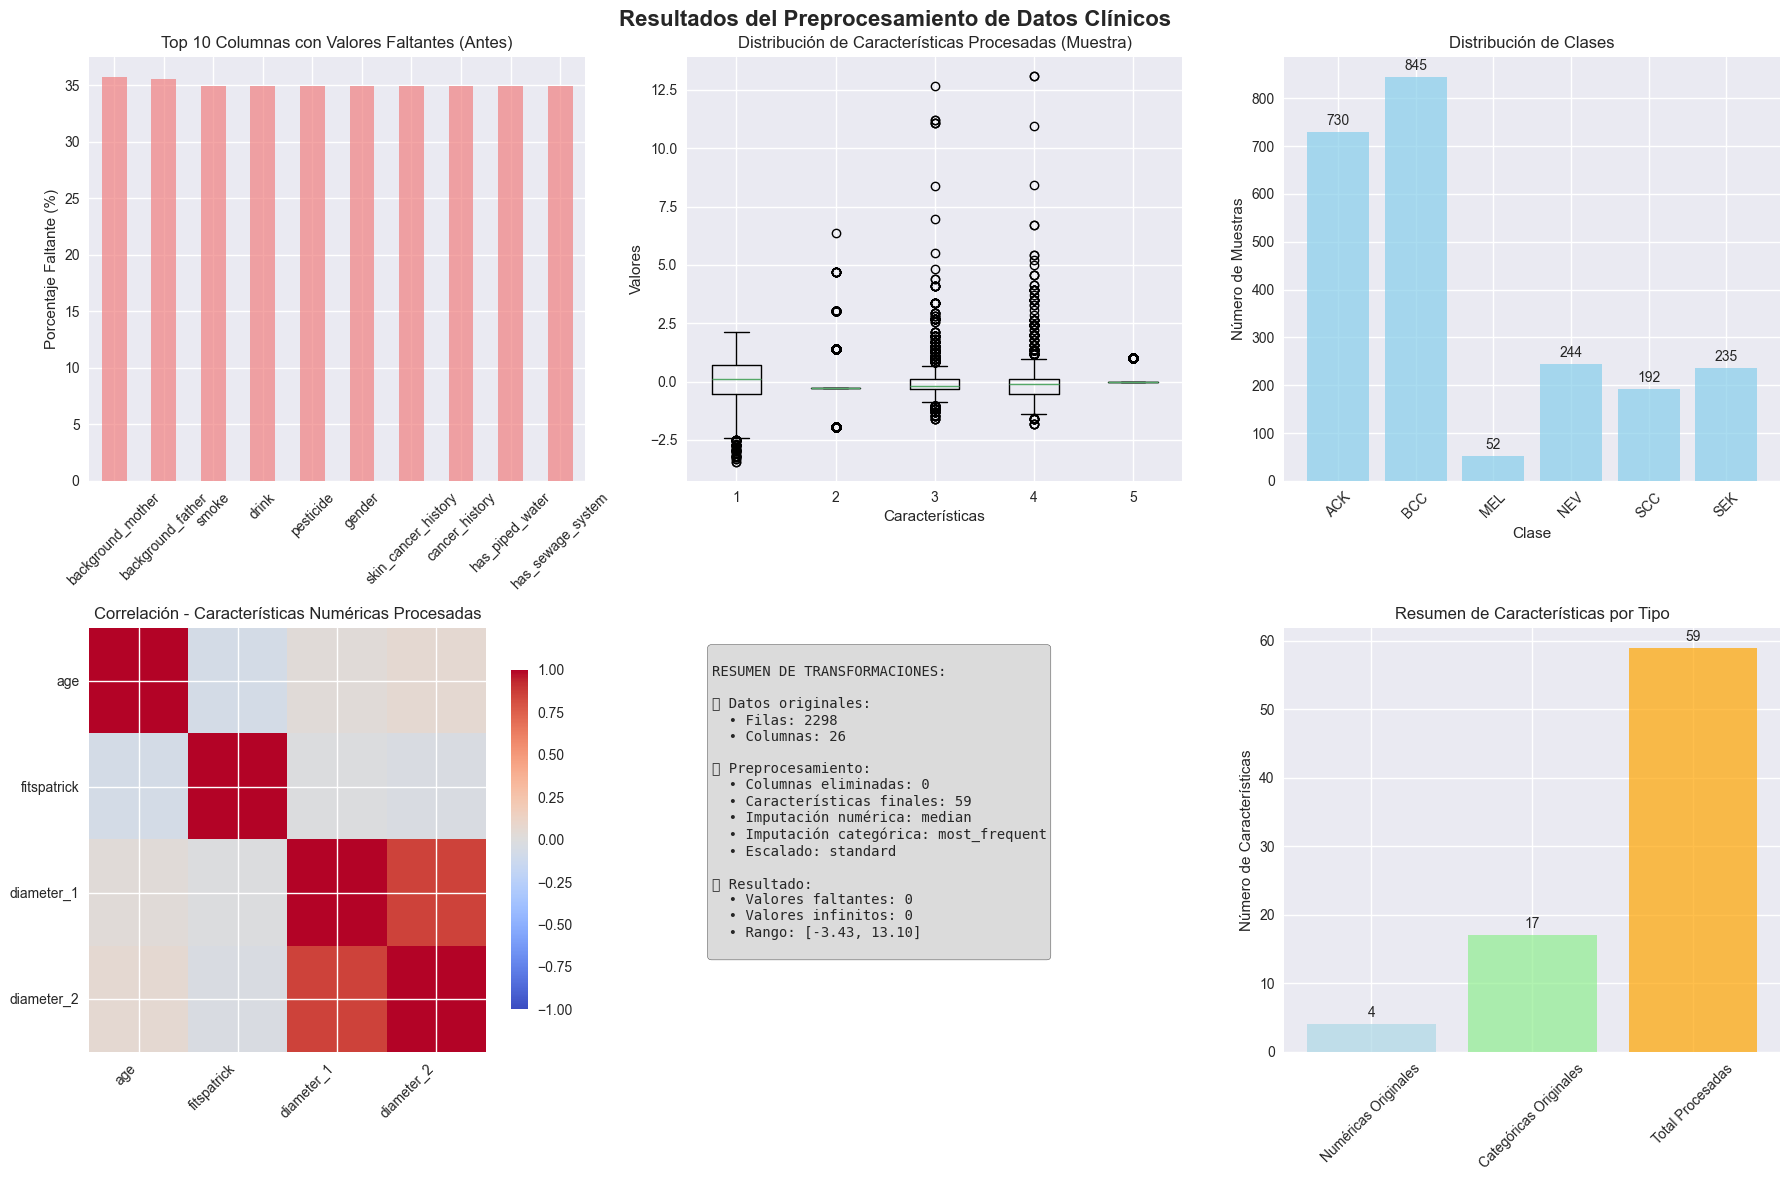

INFO:__main__:Preprocesamiento de datos clínicos completado exitosamente



✓ Resultados de preprocesamiento guardados en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\preprocessing_results.pkl


In [4]:
def preprocess_clinical_data_robust(df, exploration_results, config):
    """
    Preprocesamiento robusto de datos clínicos con manejo avanzado de valores faltantes
    
    Args:
        df: DataFrame original
        exploration_results: Resultados de la exploración
        config: Configuración del proyecto
    
    Returns:
        preprocessing_results: Diccionario con datos procesados y metadatos
    """
    
    print("="*60)
    print("PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS")
    print("="*60)
    
    logger.info("Iniciando preprocesamiento de datos clínicos")
    
    # ===== PREPARACIÓN INICIAL =====
    df_processed = df.copy()
    
    # Obtener información de columnas desde exploration_results
    id_columns = exploration_results['column_types']['id_columns']
    target_column = exploration_results['column_types']['target_column']
    numeric_columns = exploration_results['column_types']['numeric_columns']
    categorical_columns = exploration_results['column_types']['categorical_columns']
    high_missing_columns = exploration_results['high_missing_columns']
    
    print(f"📋 Información inicial:")
    print(f"  Filas: {len(df_processed)}")
    print(f"  Columnas totales: {len(df_processed.columns)}")
    print(f"  Columnas numéricas: {len(numeric_columns)}")
    print(f"  Columnas categóricas: {len(categorical_columns)}")
    print(f"  Columnas con muchos faltantes: {len(high_missing_columns)}")
    
    # ===== MANEJO DE COLUMNAS CON MUCHOS VALORES FALTANTES =====
    columns_to_drop = []
    
    if high_missing_columns and config['preprocessing']['handle_missing_values']:
        print(f"\n🗑️  Evaluando columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        
        for col in high_missing_columns:
            missing_pct = (df_processed[col].isnull().sum() / len(df_processed)) * 100
            print(f"  {col}: {missing_pct:.1f}% faltantes")
            
            # Decidir si eliminar la columna
            if missing_pct > config['preprocessing']['missing_threshold'] * 100:
                columns_to_drop.append(col)
                print(f"    → Marcada para eliminación")
            else:
                print(f"    → Conservada")
        
        if columns_to_drop:
            print(f"\n🗑️  Eliminando {len(columns_to_drop)} columnas:")
            for col in columns_to_drop:
                print(f"    - {col}")
            
            df_processed = df_processed.drop(columns=columns_to_drop)
            
            # Actualizar listas de columnas
            numeric_columns = [col for col in numeric_columns if col not in columns_to_drop]
            categorical_columns = [col for col in categorical_columns if col not in columns_to_drop]
    
    # ===== SEPARAR CARACTERÍSTICAS Y ETIQUETAS =====
    print(f"\n🎯 Separando características y etiquetas...")
    
    # Columnas a excluir de las características
    columns_to_exclude = id_columns + [target_column]
    feature_columns = [col for col in df_processed.columns if col not in columns_to_exclude]
    
    X_clinical = df_processed[feature_columns].copy()
    y_clinical = df_processed[target_column].copy()
    
    print(f"  Características clínicas: {X_clinical.shape[1]} columnas")
    print(f"  Muestras: {len(y_clinical)}")
    
    # ===== CODIFICACIÓN DE ETIQUETAS =====
    print(f"\n🏷️  Codificando etiquetas...")
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_clinical)
    
    class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(f"  Mapeo de clases: {class_mapping}")
    
    # ===== ANÁLISIS DETALLADO DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis detallado de valores faltantes en características:")
    
    missing_analysis_features = pd.DataFrame({
        'Columna': X_clinical.columns,
        'Valores_Faltantes': X_clinical.isnull().sum(),
        'Porcentaje_Faltante': (X_clinical.isnull().sum() / len(X_clinical)) * 100,
        'Tipo_Dato': X_clinical.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis_features[missing_analysis_features['Valores_Faltantes'] > 0])
    
    # ===== ESTRATEGIAS DE IMPUTACIÓN AVANZADAS =====
    print(f"\n🔧 Aplicando estrategias de imputación...")
    
    # Actualizar listas de columnas después de eliminar columnas
    numeric_features_final = [col for col in numeric_columns if col in X_clinical.columns]
    categorical_features_final = [col for col in categorical_columns if col in X_clinical.columns]
    
    print(f"  Columnas numéricas finales: {len(numeric_features_final)}")
    print(f"  Columnas categóricas finales: {len(categorical_features_final)}")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES NUMÉRICAS =====
    if numeric_features_final:
        print(f"\n📊 Configurando pipeline para variables numéricas...")
        
        # Seleccionar estrategia de imputación
        if config['preprocessing']['imputation_strategy']['numeric'] == 'knn':
            numeric_imputer = KNNImputer(n_neighbors=5)
            print(f"    Imputación: KNN (k=5)")
        else:
            numeric_imputer = SimpleImputer(strategy=config['preprocessing']['imputation_strategy']['numeric'])
            print(f"    Imputación: {config['preprocessing']['imputation_strategy']['numeric']}")
        
        # Seleccionar método de escalado
        if config['preprocessing']['scaling_method'] == 'robust':
            scaler = RobustScaler()
            print(f"    Escalado: Robust (resistente a outliers)")
        elif config['preprocessing']['scaling_method'] == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            print(f"    Escalado: MinMax (0-1)")
        else:
            scaler = StandardScaler()
            print(f"    Escalado: Standard (z-score)")
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', numeric_imputer),
            ('scaler', scaler)
        ])
    else:
        numeric_transformer = None
        print(f"    No hay variables numéricas para procesar")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES CATEGÓRICAS =====
    if categorical_features_final:
        print(f"\n📊 Configurando pipeline para variables categóricas...")
        
        categorical_imputer = SimpleImputer(
            strategy=config['preprocessing']['imputation_strategy']['categorical'],
            fill_value='desconocido' if config['preprocessing']['imputation_strategy']['categorical'] == 'constant' else None
        )
        
        print(f"    Imputación: {config['preprocessing']['imputation_strategy']['categorical']}")
        print(f"    Codificación: One-Hot Encoding")
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
        ])
    else:
        categorical_transformer = None
        print(f"    No hay variables categóricas para procesar")
    
    # ===== COMBINAR TRANSFORMADORES =====
    print(f"\n🔗 Combinando transformadores...")
    
    transformers = []
    if numeric_transformer is not None:
        transformers.append(('num', numeric_transformer, numeric_features_final))
    if categorical_transformer is not None:
        transformers.append(('cat', categorical_transformer, categorical_features_final))
    
    if transformers:
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Aplicar preprocesamiento
        print(f"    Aplicando transformaciones...")
        X_processed = preprocessor.fit_transform(X_clinical)
        
        print(f"    Forma después del preprocesamiento: {X_processed.shape}")
        
        # ===== OBTENER NOMBRES DE CARACTERÍSTICAS =====
        feature_names = []
        
        # Nombres de características numéricas
        if numeric_transformer is not None:
            feature_names.extend(numeric_features_final)
        
        # Nombres de características categóricas (después de one-hot encoding)
        if categorical_transformer is not None:
            try:
                # Para versiones más recientes de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_final)
            except AttributeError:
                # Para versiones más antiguas de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features_final)
            
            feature_names.extend(cat_feature_names)
        
        print(f"    Características finales: {len(feature_names)}")
        
        # ===== VERIFICAR CALIDAD DEL PREPROCESAMIENTO =====
        print(f"\n✅ Verificación de calidad:")
        
        # Verificar que no hay valores faltantes
        if hasattr(X_processed, 'toarray'):  # Si es una matriz sparse
            X_processed_dense = X_processed.toarray()
        else:
            X_processed_dense = X_processed
        
        nan_count = np.isnan(X_processed_dense).sum()
        inf_count = np.isinf(X_processed_dense).sum()
        
        print(f"    Valores NaN después del preprocesamiento: {nan_count}")
        print(f"    Valores infinitos después del preprocesamiento: {inf_count}")
        
        if nan_count == 0 and inf_count == 0:
            print(f"    ✓ Preprocesamiento exitoso - No hay valores problemáticos")
        else:
            print(f"    ⚠️  Advertencia: Hay valores problemáticos después del preprocesamiento")
        
        # Estadísticas básicas
        print(f"    Rango de valores: [{X_processed_dense.min():.3f}, {X_processed_dense.max():.3f}]")
        print(f"    Media: {X_processed_dense.mean():.3f}")
        print(f"    Desviación estándar: {X_processed_dense.std():.3f}")
        
    else:
        raise ValueError("No hay características válidas para procesar")
    
    # ===== CREAR VISUALIZACIÓN DEL PREPROCESAMIENTO =====
    print(f"\n📊 Generando visualización del preprocesamiento...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Resultados del Preprocesamiento de Datos Clínicos', fontsize=16, fontweight='bold')
    
    # 1. Comparación de valores faltantes antes y después
    ax1 = axes[0, 0]
    missing_before = (df[feature_columns].isnull().sum() / len(df)) * 100
    missing_before = missing_before[missing_before > 0].sort_values(ascending=False)
    
    if len(missing_before) > 0:
        missing_before.head(10).plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
        ax1.set_title('Top 10 Columnas con Valores Faltantes (Antes)')
        ax1.set_ylabel('Porcentaje Faltante (%)')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, 'No hay valores faltantes', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Valores Faltantes (Antes)')
    
    # 2. Distribución de características después del preprocesamiento (muestra)
    ax2 = axes[0, 1]
    if X_processed.shape[1] > 0:
        # Mostrar distribución de las primeras 5 características
        sample_features = X_processed_dense[:, :min(5, X_processed.shape[1])]
        ax2.boxplot(sample_features)
        ax2.set_title('Distribución de Características Procesadas (Muestra)')
        ax2.set_xlabel('Características')
        ax2.set_ylabel('Valores')
    
    # 3. Distribución de clases
    ax3 = axes[0, 2]
    unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
    class_names = [label_encoder.classes_[i] for i in unique_classes]
    
    bars = ax3.bar(class_names, class_counts, color='skyblue', alpha=0.7)
    ax3.set_title('Distribución de Clases')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Número de Muestras')
    ax3.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, class_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 4. Matriz de correlación de características numéricas procesadas
    ax4 = axes[1, 0]
    if len(numeric_features_final) > 1:
        # Obtener solo las características numéricas procesadas
        num_features_processed = X_processed_dense[:, :len(numeric_features_final)]
        corr_matrix = np.corrcoef(num_features_processed.T)
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación - Características Numéricas Procesadas')
        ax4.set_xticks(range(len(numeric_features_final)))
        ax4.set_yticks(range(len(numeric_features_final)))
        ax4.set_xticklabels(numeric_features_final, rotation=45, ha='right')
        ax4.set_yticklabels(numeric_features_final)
        
        # Añadir colorbar
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\nnuméricas para correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación - Características Numéricas')
    
    # 5. Resumen de transformaciones aplicadas
    ax5 = axes[1, 1]
    ax5.axis('off')
    
    summary_text = f"""
RESUMEN DE TRANSFORMACIONES:

📊 Datos originales:
  • Filas: {len(df)}
  • Columnas: {len(df.columns)}

🔧 Preprocesamiento:
  • Columnas eliminadas: {len(columns_to_drop)}
  • Características finales: {X_processed.shape[1]}
  • Imputación numérica: {config['preprocessing']['imputation_strategy']['numeric']}
  • Imputación categórica: {config['preprocessing']['imputation_strategy']['categorical']}
  • Escalado: {config['preprocessing']['scaling_method']}

✅ Resultado:
  • Valores faltantes: {nan_count}
  • Valores infinitos: {inf_count}
  • Rango: [{X_processed_dense.min():.2f}, {X_processed_dense.max():.2f}]
    """
    
    ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # 6. Estadísticas de características por tipo
    ax6 = axes[1, 2]
    
    feature_type_counts = {
        'Numéricas Originales': len(numeric_features_final),
        'Categóricas Originales': len(categorical_features_final),
        'Total Procesadas': X_processed.shape[1]
    }
    
    bars = ax6.bar(feature_type_counts.keys(), feature_type_counts.values(), 
                  color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
    ax6.set_title('Resumen de Características por Tipo')
    ax6.set_ylabel('Número de Características')
    ax6.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts.values()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts.values())*0.01, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'preprocessing_results.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    preprocessing_results = {
        'X_processed': X_processed,
        'y_encoded': y_encoded,
        'feature_names': feature_names,
        'label_encoder': label_encoder,
        'preprocessor': preprocessor,
        'class_mapping': class_mapping,
        'processing_summary': {
            'original_shape': df.shape,
            'processed_shape': X_processed.shape,
            'columns_dropped': columns_to_drop,
            'numeric_features': numeric_features_final,
            'categorical_features': categorical_features_final,
            'nan_count_after': int(nan_count),
            'inf_count_after': int(inf_count),
            'value_range': [float(X_processed_dense.min()), float(X_processed_dense.max())],
            'mean_value': float(X_processed_dense.mean()),
            'std_value': float(X_processed_dense.std())
        }
    }
    
    # Guardar resultados de preprocesamiento
    preprocessing_path = os.path.join(config['paths']['output_folder'], 'preprocessing_results.pkl')
    with open(preprocessing_path, 'wb') as f:
        pickle.dump(preprocessing_results, f)
    
    print(f"\n✓ Resultados de preprocesamiento guardados en: {preprocessing_path}")
    
    logger.info("Preprocesamiento de datos clínicos completado exitosamente")
    
    return preprocessing_results

# ===== EJECUTAR PREPROCESAMIENTO =====
preprocessing_results = preprocess_clinical_data_robust(df, exploration_results, CONFIG)


## 4. Extracción de características de imágenes optimizada

INFO:__main__:Iniciando extracción de características de imágenes



EXTRACCIÓN DE CARACTERÍSTICAS DE IMÁGENES
EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES
📁 Carpeta de imágenes: C:\Users\torre\Downloads\PAD_UFES_Extractor\data\images
📐 Tamaño objetivo: (224, 224)
🖼️  Total de imágenes en metadata: 2298

🔧 Configuración de extracción:
  Color: ✓
  Textura: ✓
  Forma: ✓
  Estadísticas: ✓

🔄 Iniciando extracción de características...
  Progreso: 4.4% | Procesadas: 100 | Errores: 0 | Tiempo restante: 32.8 min
  Progreso: 8.7% | Procesadas: 200 | Errores: 0 | Tiempo restante: 31.4 min
  Progreso: 13.1% | Procesadas: 300 | Errores: 0 | Tiempo restante: 29.1 min
  Progreso: 17.4% | Procesadas: 400 | Errores: 0 | Tiempo restante: 27.3 min
  Progreso: 21.8% | Procesadas: 500 | Errores: 0 | Tiempo restante: 25.4 min
  Progreso: 26.1% | Procesadas: 600 | Errores: 0 | Tiempo restante: 24.0 min
  Progreso: 30.5% | Procesadas: 700 | Errores: 0 | Tiempo restante: 22.6 min
  Progreso: 34.8% | Procesadas: 800 | Errores: 0 | Tiempo restante: 21.0 min
  Progreso

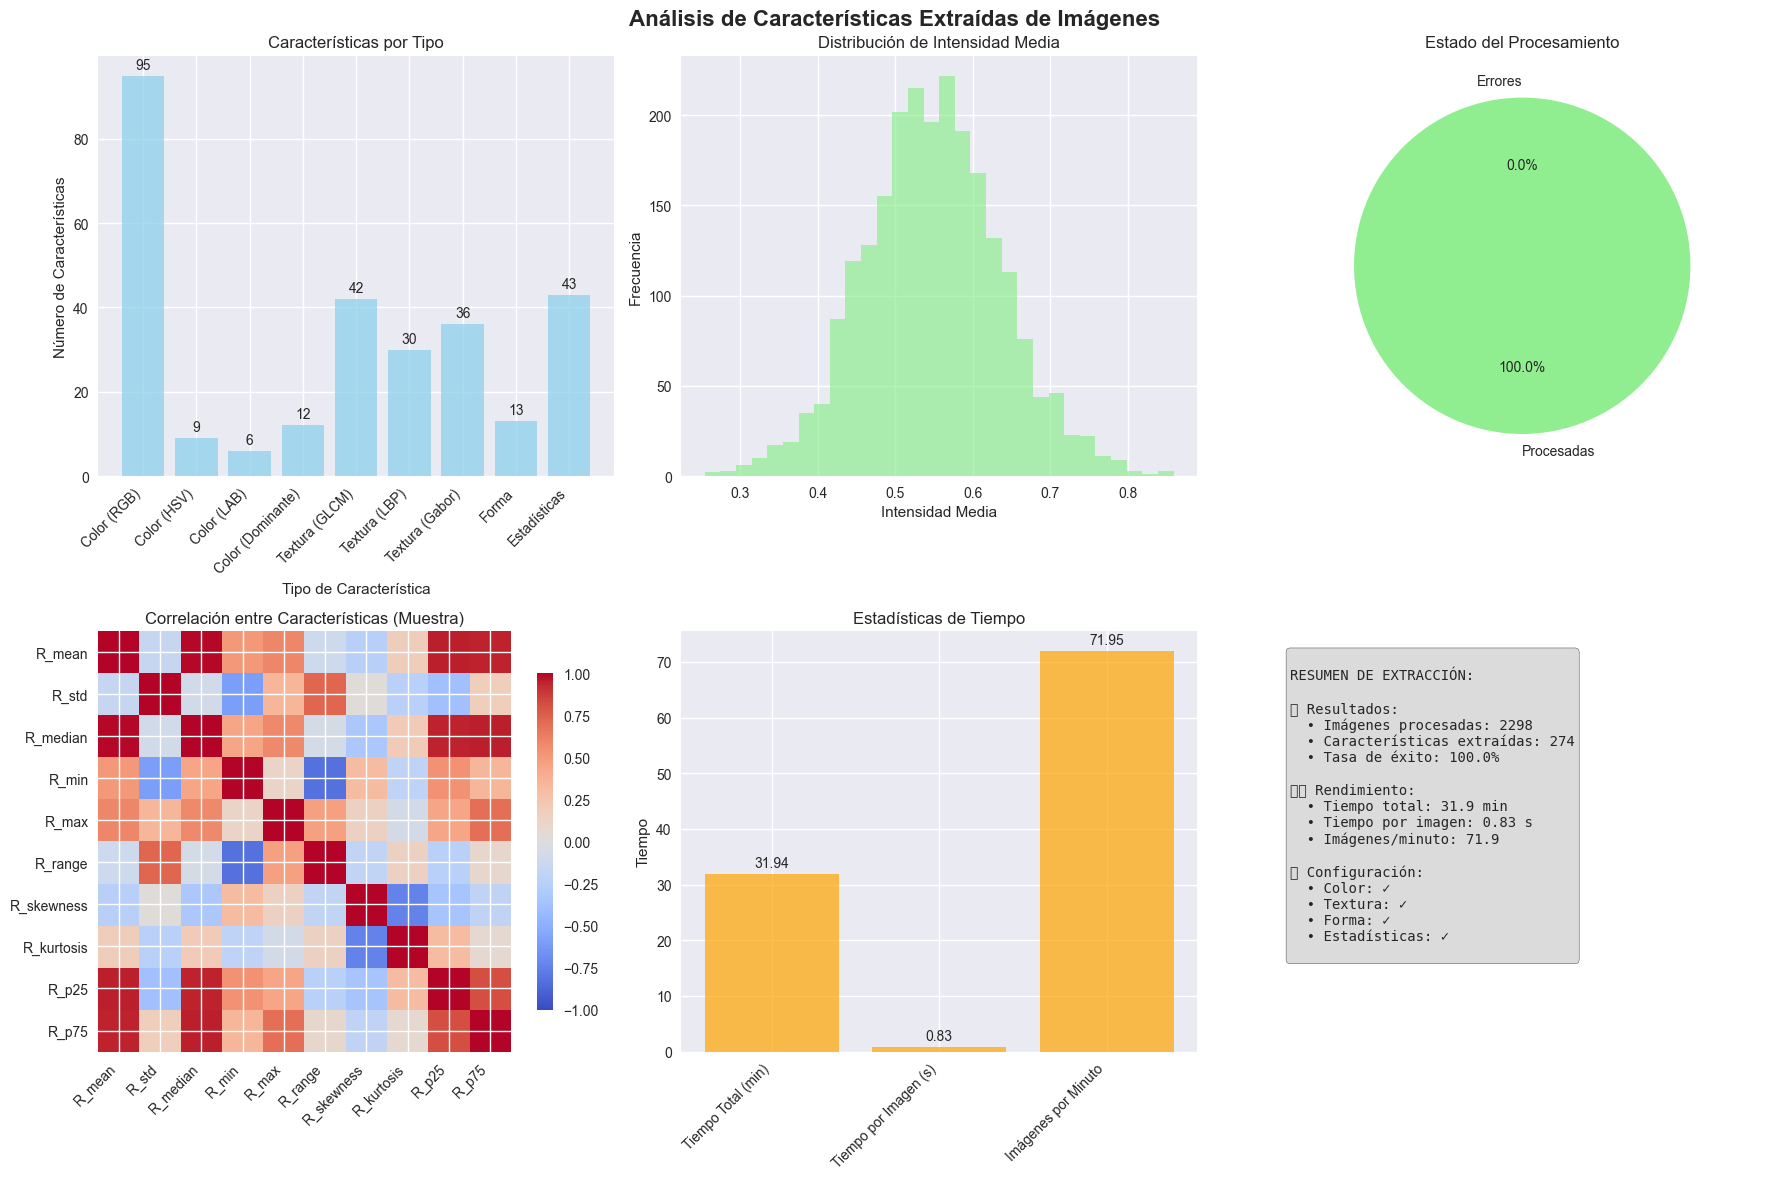

INFO:__main__:Extracción de características de imágenes completada exitosamente


  ✓ Metadatos guardados en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\image_extraction_metadata.json


In [5]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, feature, filters, measure, transform, exposure
from skimage.transform import resize
from skimage.util import img_as_float
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def extract_image_features_optimized(df, config):
    """
    Extracción optimizada de características de imágenes con múltiples tipos de descriptores
    
    Args:
        df: DataFrame con metadata
        config: Configuración del proyecto
    
    Returns:
        image_features_results: Diccionario con características extraídas y metadatos
    """
    
    print("="*60)
    print("EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES")
    print("="*60)
    
    logger.info("Iniciando extracción de características de imágenes")
    
    # ===== CONFIGURACIÓN INICIAL =====
    images_folder = config['paths']['images_folder']
    target_size = config['data_params']['target_image_size']
    
    print(f"📁 Carpeta de imágenes: {images_folder}")
    print(f"📐 Tamaño objetivo: {target_size}")
    print(f"🖼️  Total de imágenes en metadata: {len(df)}")
    
    # Verificar configuración de extracción
    extract_config = config['feature_extraction']
    print(f"\n🔧 Configuración de extracción:")
    print(f"  Color: {'✓' if extract_config['extract_color_features'] else '✗'}")
    print(f"  Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}")
    print(f"  Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}")
    print(f"  Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}")
    
    # ===== FUNCIONES AUXILIARES PARA EXTRACCIÓN =====
    
    def load_and_preprocess_image(img_path, target_size):
        """Carga y preprocesa una imagen, manejando diferentes formatos"""
        try:
            img = io.imread(img_path)
            
            # Redimensionar
            img_resized = resize(img, target_size, anti_aliasing=True)
            
            # Manejar diferentes formatos
            if len(img_resized.shape) == 2:  # Escala de grises
                img_gray = img_resized
                img_rgb = np.stack([img_resized]*3, axis=-1)  # Convertir a RGB
            elif img_resized.shape[2] == 4:  # RGBA
                img_rgb = img_resized[:, :, :3]  # Descartar canal alpha
                img_gray = color.rgb2gray(img_rgb)
            elif img_resized.shape[2] == 3:  # RGB
                img_rgb = img_resized
                img_gray = color.rgb2gray(img_rgb)
            else:
                # Formato no soportado
                raise ValueError(f"Formato de imagen no soportado con {img_resized.shape[2]} canales")
                
            return img_rgb, img_gray
            
        except Exception as e:
            logger.error(f"Error cargando imagen {img_path}: {e}")
            return None, None
    
    def extract_color_features(img, config):
        """Extrae características de color de la imagen"""
        features = {}
        
        if len(img.shape) > 2 and img.shape[2] >= 3:
            # ===== CARACTERÍSTICAS RGB =====
            for i, channel in enumerate(['R', 'G', 'B']):
                channel_data = img[:, :, i]
                
                # Estadísticas básicas
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
                features[f'{channel}_min'] = np.min(channel_data)
                features[f'{channel}_max'] = np.max(channel_data)
                features[f'{channel}_range'] = np.max(channel_data) - np.min(channel_data)
                
                # Momentos estadísticos
                features[f'{channel}_skewness'] = np.mean((channel_data - np.mean(channel_data))**3) / (np.std(channel_data)**3 + 1e-7)
                features[f'{channel}_kurtosis'] = np.mean((channel_data - np.mean(channel_data))**4) / (np.std(channel_data)**4 + 1e-7)
                
                # Percentiles
                features[f'{channel}_p25'] = np.percentile(channel_data, 25)
                features[f'{channel}_p75'] = np.percentile(channel_data, 75)
                features[f'{channel}_iqr'] = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
                
                # Histograma
                hist, _ = np.histogram(channel_data, bins=config['color_bins'], range=[0, 1])
                for j, h in enumerate(hist):
                    features[f'{channel}_hist_{j}'] = h
            
            # ===== CARACTERÍSTICAS HSV =====
            img_hsv = color.rgb2hsv(img)
            for i, channel in enumerate(['H', 'S', 'V']):
                channel_data = img_hsv[:, :, i]
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
            
            # ===== CARACTERÍSTICAS LAB =====
            try:
                img_lab = color.rgb2lab(img)
                for i, channel in enumerate(['L', 'A', 'B_lab']):
                    channel_data = img_lab[:, :, i]
                    features[f'{channel}_mean'] = np.mean(channel_data)
                    features[f'{channel}_std'] = np.std(channel_data)
            except:
                pass  # En caso de error con la conversión LAB
            
            # ===== DOMINANCIA DE COLOR =====
            # Calcular color dominante
            img_reshaped = img.reshape(-1, 3)
            from sklearn.cluster import KMeans
            
            try:
                kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
                kmeans.fit(img_reshaped)
                
                # Obtener colores dominantes y sus proporciones
                colors = kmeans.cluster_centers_
                labels = kmeans.labels_
                
                for i in range(3):
                    proportion = np.sum(labels == i) / len(labels)
                    features[f'dominant_color_{i}_R'] = colors[i, 0]
                    features[f'dominant_color_{i}_G'] = colors[i, 1]
                    features[f'dominant_color_{i}_B'] = colors[i, 2]
                    features[f'dominant_color_{i}_proportion'] = proportion
            except:
                # En caso de error, usar valores por defecto
                for i in range(3):
                    features[f'dominant_color_{i}_R'] = 0
                    features[f'dominant_color_{i}_G'] = 0
                    features[f'dominant_color_{i}_B'] = 0
                    features[f'dominant_color_{i}_proportion'] = 0
        
        return features
    
    def extract_texture_features(img_gray, config):
        """Extrae características de textura de la imagen en escala de grises"""
        features = {}
        
        # Convertir a enteros para GLCM
        img_gray_int = (img_gray * 255).astype(np.uint8)
        
        # ===== GLCM (Gray Level Co-occurrence Matrix) =====
        distances = config['glcm_distances']
        angles_deg = config['glcm_angles']
        angles_rad = [np.deg2rad(angle) for angle in angles_deg]
        
        try:
            glcm = feature.graycomatrix(
                img_gray_int, 
                distances=distances, 
                angles=angles_rad, 
                levels=32,  # Reducir niveles para eficiencia
                symmetric=True, 
                normed=True
            )
            
            # Propiedades de GLCM
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            
            for prop in properties:
                try:
                    if prop == 'ASM':
                        prop_values = feature.graycoprops(glcm, 'ASM')
                    else:
                        prop_values = feature.graycoprops(glcm, prop)
                    
                    # Estadísticas de la propiedad a través de distancias y ángulos
                    features[f'glcm_{prop}_mean'] = np.mean(prop_values)
                    features[f'glcm_{prop}_std'] = np.std(prop_values)
                    features[f'glcm_{prop}_min'] = np.min(prop_values)
                    features[f'glcm_{prop}_max'] = np.max(prop_values)
                    
                    # Valores específicos por distancia (promediando ángulos)
                    for i, dist in enumerate(distances):
                        features[f'glcm_{prop}_dist_{dist}'] = np.mean(prop_values[i, :])
                except:
                    # En caso de error, asignar valores por defecto
                    features[f'glcm_{prop}_mean'] = 0
                    features[f'glcm_{prop}_std'] = 0
                    features[f'glcm_{prop}_min'] = 0
                    features[f'glcm_{prop}_max'] = 0
                    
                    for dist in distances:
                        features[f'glcm_{prop}_dist_{dist}'] = 0
        except:
            # En caso de error con GLCM, asignar valores por defecto
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for prop in properties:
                features[f'glcm_{prop}_mean'] = 0
                features[f'glcm_{prop}_std'] = 0
                features[f'glcm_{prop}_min'] = 0
                features[f'glcm_{prop}_max'] = 0
                for dist in distances:
                    features[f'glcm_{prop}_dist_{dist}'] = 0
        
        # ===== LBP (Local Binary Patterns) =====
        try:
            radius = config['lbp_radius']
            n_points = config['lbp_n_points']
            
            lbp = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
            
            # Histograma de LBP
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
            
            # Normalizar histograma
            lbp_hist = lbp_hist / (np.sum(lbp_hist) + 1e-7)
            
            for i, h in enumerate(lbp_hist):
                features[f'lbp_hist_{i}'] = h
            
            # Estadísticas de LBP
            features['lbp_mean'] = np.mean(lbp)
            features['lbp_std'] = np.std(lbp)
            features['lbp_uniformity'] = np.sum(lbp_hist**2)  # Medida de uniformidad
            features['lbp_entropy'] = -np.sum(lbp_hist * np.log2(lbp_hist + 1e-7))  # Entropía
            
        except:
            # En caso de error con LBP
            n_points = config['lbp_n_points']
            for i in range(n_points + 2):
                features[f'lbp_hist_{i}'] = 0
            features['lbp_mean'] = 0
            features['lbp_std'] = 0
            features['lbp_uniformity'] = 0
            features['lbp_entropy'] = 0
        
        # ===== FILTROS DE GABOR =====
        try:
            # Aplicar filtros de Gabor con diferentes frecuencias y orientaciones
            gabor_responses = []
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            
            for freq in frequencies:
                for orient in orientations:
                    try:
                        gabor_real, _ = filters.gabor(img_gray, frequency=freq, 
                                                    theta=np.deg2rad(orient))
                        gabor_responses.append(gabor_real)
                        
                        # Estadísticas de la respuesta de Gabor
                        features[f'gabor_f{freq}_o{orient}_mean'] = np.mean(np.abs(gabor_real))
                        features[f'gabor_f{freq}_o{orient}_std'] = np.std(gabor_real)
                        features[f'gabor_f{freq}_o{orient}_energy'] = np.sum(gabor_real**2)
                    except:
                        features[f'gabor_f{freq}_o{orient}_mean'] = 0
                        features[f'gabor_f{freq}_o{orient}_std'] = 0
                        features[f'gabor_f{freq}_o{orient}_energy'] = 0
        except:
            # En caso de error con Gabor
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            for freq in frequencies:
                for orient in orientations:
                    features[f'gabor_f{freq}_o{orient}_mean'] = 0
                    features[f'gabor_f{freq}_o{orient}_std'] = 0
                    features[f'gabor_f{freq}_o{orient}_energy'] = 0
        
        return features
    
    def extract_shape_features(img_gray, config):
        """Extrae características de forma de la imagen"""
        features = {}
        
        try:
            # ===== DETECCIÓN DE BORDES =====
            # Canny edge detection
            edges_canny = feature.canny(img_gray, sigma=1.0, low_threshold=0.1, high_threshold=0.2)
            features['edge_density_canny'] = np.sum(edges_canny) / edges_canny.size
            features['edge_count_canny'] = np.sum(edges_canny)
            
            # Sobel edges
            edges_sobel_h = filters.sobel_h(img_gray)
            edges_sobel_v = filters.sobel_v(img_gray)
            edges_sobel_mag = np.sqrt(edges_sobel_h**2 + edges_sobel_v**2)
            
            features['sobel_mean'] = np.mean(edges_sobel_mag)
            features['sobel_std'] = np.std(edges_sobel_mag)
            features['sobel_max'] = np.max(edges_sobel_mag)
            
            # ===== SEGMENTACIÓN Y REGIONES =====
            # Umbralización de Otsu para segmentación básica
            try:
                threshold_otsu = filters.threshold_otsu(img_gray)
                binary_otsu = img_gray > threshold_otsu
                
                # Propiedades de regiones
                labeled_img = measure.label(binary_otsu)
                regions = measure.regionprops(labeled_img)
                
                if regions:
                    # Estadísticas de las regiones
                    areas = [region.area for region in regions]
                    perimeters = [region.perimeter for region in regions if region.perimeter > 0]
                    eccentricities = [region.eccentricity for region in regions]
                    solidities = [region.solidity for region in regions]
                    
                    features['num_regions'] = len(regions)
                    features['total_area'] = np.sum(areas)
                    features['mean_area'] = np.mean(areas)
                    features['std_area'] = np.std(areas)
                    features['max_area'] = np.max(areas)
                    
                    if perimeters:
                        features['mean_perimeter'] = np.mean(perimeters)
                        features['std_perimeter'] = np.std(perimeters)
                        
                        # Compacidad (4π*área/perímetro²)
                        compactness = [4 * np.pi * areas[i] / (perimeters[i]**2) 
                                     for i in range(min(len(areas), len(perimeters)))]
                        if compactness:
                            features['mean_compactness'] = np.mean(compactness)
                            features['std_compactness'] = np.std(compactness)
                        else:
                            features['mean_compactness'] = 0
                            features['std_compactness'] = 0
                    else:
                        features['mean_perimeter'] = 0
                        features['std_perimeter'] = 0
                        features['mean_compactness'] = 0
                        features['std_compactness'] = 0
                    
                    features['mean_eccentricity'] = np.mean(eccentricities)
                    features['std_eccentricity'] = np.std(eccentricities)
                    features['mean_solidity'] = np.mean(solidities)
                    features['std_solidity'] = np.std(solidities)
                    
                    # Región más grande
                    largest_region = max(regions, key=lambda r: r.area)
                    features['largest_region_area'] = largest_region.area
                    features['largest_region_eccentricity'] = largest_region.eccentricity
                    features['largest_region_solidity'] = largest_region.solidity
                    
                else:
                    # No se encontraron regiones
                    region_features = ['num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                                     'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                                     'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                                     'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity']
                    for feat in region_features:
                        features[feat] = 0
                        
            except:
                # Error en segmentación
                region_features = ['num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                                 'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                                 'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                                 'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity']
                for feat in region_features:
                    features[feat] = 0
            
            # ===== TRANSFORMADA DE HOUGH PARA CÍRCULOS =====
            try:
                # Detectar círculos usando transformada de Hough
                edges_for_hough = feature.canny(img_gray, sigma=2, low_threshold=0.1, high_threshold=0.2)
                hough_radii = np.arange(10, 50, 5)
                hough_res = feature.hough_circle(edges_for_hough, hough_radii)
                
                # Encontrar picos en el espacio de Hough
                accums, cx, cy, radii = feature.hough_circle_peaks(hough_res, hough_radii, 
                                                                  total_num_peaks=5)
                
                features['num_circles_detected'] = len(accums)
                if len(accums) > 0:
                    features['strongest_circle_accumulator'] = np.max(accums)
                    features['mean_circle_radius'] = np.mean(radii)
                    features['std_circle_radius'] = np.std(radii)
                else:
                    features['strongest_circle_accumulator'] = 0
                    features['mean_circle_radius'] = 0
                    features['std_circle_radius'] = 0
                    
            except:
                features['num_circles_detected'] = 0
                features['strongest_circle_accumulator'] = 0
                features['mean_circle_radius'] = 0
                features['std_circle_radius'] = 0
                
        except Exception as e:
            # En caso de error general en extracción de forma
            shape_features = ['edge_density_canny', 'edge_count_canny', 'sobel_mean', 'sobel_std', 'sobel_max',
                            'num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                            'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                            'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                            'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity',
                            'num_circles_detected', 'strongest_circle_accumulator', 'mean_circle_radius', 'std_circle_radius']
            for feat in shape_features:
                features[feat] = 0
        
        return features
    
    def extract_statistical_features(img_gray, config):
        """Extrae características estadísticas generales de la imagen"""
        features = {}
        
        # ===== ESTADÍSTICAS BÁSICAS =====
        features['mean_intensity'] = np.mean(img_gray)
        features['std_intensity'] = np.std(img_gray)
        features['median_intensity'] = np.median(img_gray)
        features['min_intensity'] = np.min(img_gray)
        features['max_intensity'] = np.max(img_gray)
        features['range_intensity'] = np.max(img_gray) - np.min(img_gray)
        
        # ===== PERCENTILES =====
        percentiles = [5, 10, 25, 75, 90, 95]
        for p in percentiles:
            features[f'percentile_{p}'] = np.percentile(img_gray, p)
        
        features['iqr'] = np.percentile(img_gray, 75) - np.percentile(img_gray, 25)
        
        # ===== MOMENTOS ESTADÍSTICOS =====
        features['skewness'] = np.mean((img_gray - np.mean(img_gray))**3) / (np.std(img_gray)**3 + 1e-7)
        features['kurtosis'] = np.mean((img_gray - np.mean(img_gray))**4) / (np.std(img_gray)**4 + 1e-7)
        
        # ===== ENTROPÍA =====
        # Calcular entropía de la imagen
        hist, _ = np.histogram(img_gray, bins=256, range=[0, 1])
        hist = hist / (np.sum(hist) + 1e-7)  # Normalizar
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features['entropy'] = entropy
        
        # ===== ENERGÍA =====
        features['energy'] = np.sum(img_gray**2)
        features['rms'] = np.sqrt(np.mean(img_gray**2))
        
        # ===== VARIANZA LOCAL =====
        # Calcular varianza en ventanas locales
        try:
            from skimage.filters.rank import variance
            from skimage.morphology import disk
            
            # Convertir a uint8 para filtros de rango
            img_uint8 = (img_gray * 255).astype(np.uint8)
            local_variance = variance(img_uint8, disk(5))
            
            features['local_variance_mean'] = np.mean(local_variance)
            features['local_variance_std'] = np.std(local_variance)
            features['local_variance_max'] = np.max(local_variance)
        except:
            features['local_variance_mean'] = 0
            features['local_variance_std'] = 0
            features['local_variance_max'] = 0
        
        return features
    
    def process_single_image(img_path, config):
        """Procesa una sola imagen y extrae todas las características"""
        try:
            # Cargar y preprocesar imagen
            img_rgb, img_gray = load_and_preprocess_image(img_path, target_size)
            if img_rgb is None:
                return None
                
            # Diccionario para almacenar todas las características
            all_features = {}
            
            # Extraer características según configuración
            if config['extract_color_features']:
                color_features = extract_color_features(img_rgb, config)
                all_features.update(color_features)
            
            if config['extract_texture_features']:
                texture_features = extract_texture_features(img_gray, config)
                all_features.update(texture_features)
            
            if config['extract_shape_features']:
                shape_features = extract_shape_features(img_gray, config)
                all_features.update(shape_features)
            
            if config['extract_statistical_features']:
                statistical_features = extract_statistical_features(img_gray, config)
                all_features.update(statistical_features)
            
            return all_features
            
        except Exception as e:
            logger.warning(f"Error procesando imagen {img_path}: {e}")
            return None
    
    # ===== PROCESAMIENTO PRINCIPAL =====
    print(f"\n🔄 Iniciando extracción de características...")
    
    image_features = {}
    processed_count = 0
    error_count = 0
    start_time = time.time()
    
    # Crear barra de progreso simple
    total_images = len(df)
    
    for index, row in df.iterrows():
        img_id = row['img_id']
        img_path = os.path.join(images_folder, img_id)
        
        # Verificar si la imagen existe
        if os.path.exists(img_path):
            features = process_single_image(img_path, extract_config)
            if features is not None:
                image_features[img_id] = features
                processed_count += 1
            else:
                error_count += 1
        else:
            error_count += 1
        
        # Mostrar progreso cada 100 imágenes
        if (processed_count + error_count) % 100 == 0:
            elapsed_time = time.time() - start_time
            progress = (processed_count + error_count) / total_images * 100
            estimated_total = elapsed_time / (processed_count + error_count) * total_images
            remaining_time = estimated_total - elapsed_time
            
            print(f"  Progreso: {progress:.1f}% | Procesadas: {processed_count} | Errores: {error_count} | "
                  f"Tiempo restante: {remaining_time/60:.1f} min")
    
    total_time = time.time() - start_time
    
    print(f"\n✅ Extracción completada:")
    print(f"  Tiempo total: {total_time/60:.1f} minutos")
    print(f"  Imágenes procesadas: {processed_count}")
    print(f"  Errores: {error_count}")
    print(f"  Tasa de éxito: {processed_count/(processed_count+error_count)*100:.1f}%")
    
    if processed_count == 0:
        raise ValueError("No se pudo procesar ninguna imagen. Verificar rutas y configuración.")
    
    # ===== CONVERTIR A DATAFRAME =====
    print(f"\n📊 Creando DataFrame de características...")
    
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'img_id'
    image_features_df = image_features_df.reset_index()
    
    print(f"  Forma del DataFrame: {image_features_df.shape}")
    print(f"  Características extraídas: {image_features_df.shape[1] - 1}")  # -1 por la columna img_id
    
    # ===== ANÁLISIS DE CARACTERÍSTICAS EXTRAÍDAS =====
    print(f"\n🔍 Análisis de características extraídas:")
    
    feature_columns = [col for col in image_features_df.columns if col != 'img_id']
    
    # Estadísticas básicas
    print(f"  Total de características: {len(feature_columns)}")
    
    # Contar características por tipo
    feature_types = {
        'Color (RGB)': len([col for col in feature_columns if any(c in col for c in ['R_', 'G_', 'B_'])]),
        'Color (HSV)': len([col for col in feature_columns if any(c in col for c in ['H_', 'S_', 'V_'])]),
        'Color (LAB)': len([col for col in feature_columns if any(c in col for c in ['L_', 'A_', 'B_lab'])]),
        'Color (Dominante)': len([col for col in feature_columns if 'dominant_color' in col]),
        'Textura (GLCM)': len([col for col in feature_columns if 'glcm_' in col]),
        'Textura (LBP)': len([col for col in feature_columns if 'lbp_' in col]),
        'Textura (Gabor)': len([col for col in feature_columns if 'gabor_' in col]),
        'Forma': len([col for col in feature_columns if any(s in col for s in ['edge_', 'sobel_', 'region', 'circle'])]),
        'Estadísticas': len([col for col in feature_columns if any(s in col for s in ['mean_', 'std_', 'median_', 'percentile_', 'entropy', 'energy'])])
    }
    
    for feat_type, count in feature_types.items():
        if count > 0:
            print(f"    {feat_type}: {count}")
    
    # Verificar valores problemáticos
    nan_count = image_features_df[feature_columns].isnull().sum().sum()
    inf_count = np.isinf(image_features_df[feature_columns].select_dtypes(include=[np.number])).sum().sum()
    
    print(f"\n🔍 Verificación de calidad:")
    print(f"  Valores NaN: {nan_count}")
    print(f"  Valores infinitos: {inf_count}")
    
    if nan_count > 0 or inf_count > 0:
        print(f"  ⚠️  Limpiando valores problemáticos...")
        
        # Reemplazar NaN e infinitos con 0
        image_features_df[feature_columns] = image_features_df[feature_columns].replace([np.inf, -np.inf], np.nan)
        image_features_df[feature_columns] = image_features_df[feature_columns].fillna(0)
        
        print(f"  ✓ Valores problemáticos reemplazados con 0")
    
    # ===== GUARDAR RESULTADOS =====
    print(f"\n💾 Guardando resultados...")
    
    # Guardar DataFrame de características
    features_path = os.path.join(config['paths']['output_folder'], 'image_features.csv')
    image_features_df.to_csv(features_path, index=False)
    print(f"  ✓ Características guardadas en: {features_path}")
    
    # Guardar también en formato pickle para preservar tipos de datos
    features_pkl_path = os.path.join(config['paths']['output_folder'], 'image_features.pkl')
    image_features_df.to_pickle(features_pkl_path)
    print(f"  ✓ Características (pickle) guardadas en: {features_pkl_path}")
    
    # ===== CREAR VISUALIZACIÓN DE CARACTERÍSTICAS =====
    print(f"\n📊 Generando visualización de características...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis de Características Extraídas de Imágenes', fontsize=16, fontweight='bold')
    
    # 1. Distribución de tipos de características
    ax1 = axes[0, 0]
    feature_type_counts = [count for count in feature_types.values() if count > 0]
    feature_type_names = [name for name, count in feature_types.items() if count > 0]
    
    bars = ax1.bar(range(len(feature_type_names)), feature_type_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Características por Tipo')
    ax1.set_xlabel('Tipo de Característica')
    ax1.set_ylabel('Número de Características')
    ax1.set_xticks(range(len(feature_type_names)))
    ax1.set_xticklabels(feature_type_names, rotation=45, ha='right')
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 2. Distribución de una característica de ejemplo (mean_intensity)
    ax2 = axes[0, 1]
    if 'mean_intensity' in feature_columns:
        ax2.hist(image_features_df['mean_intensity'], bins=30, alpha=0.7, color='lightgreen')
        ax2.set_title('Distribución de Intensidad Media')
        ax2.set_xlabel('Intensidad Media')
        ax2.set_ylabel('Frecuencia')
    else:
        ax2.text(0.5, 0.5, 'mean_intensity\nno disponible', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Distribución de Intensidad Media')
    
    # 3. Estadísticas de procesamiento
    ax3 = axes[0, 2]
    processing_stats = {
        'Procesadas': processed_count,
        'Errores': error_count
    }
    
    colors = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = ax3.pie(processing_stats.values(), labels=processing_stats.keys(), 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Estado del Procesamiento')
    
    # 4. Correlación entre características (muestra)
    ax4 = axes[1, 0]
    if len(feature_columns) > 1:
        # Seleccionar una muestra de características para correlación
        sample_features = feature_columns[:min(10, len(feature_columns))]
        corr_matrix = image_features_df[sample_features].corr()
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación entre Características (Muestra)')
        ax4.set_xticks(range(len(sample_features)))
        ax4.set_yticks(range(len(sample_features)))
        ax4.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features], 
                           rotation=45, ha='right')
        ax4.set_yticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features])
        
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\npara correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación entre Características')
    
    # 5. Tiempo de procesamiento
    ax5 = axes[1, 1]
    time_per_image = total_time / processed_count if processed_count > 0 else 0
    
    time_stats = {
        'Tiempo Total (min)': total_time / 60,
        'Tiempo por Imagen (s)': time_per_image,
        'Imágenes por Minuto': 60 / time_per_image if time_per_image > 0 else 0
    }
    
    bars = ax5.bar(range(len(time_stats)), list(time_stats.values()), color='orange', alpha=0.7)
    ax5.set_title('Estadísticas de Tiempo')
    ax5.set_xticks(range(len(time_stats)))
    ax5.set_xticklabels(list(time_stats.keys()), rotation=45, ha='right')
    ax5.set_ylabel('Tiempo')
    
    # Añadir etiquetas de valores
    for bar, value in zip(bars, time_stats.values()):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(time_stats.values())*0.01, 
                f'{value:.2f}', ha='center', va='bottom')
    
    # 6. Resumen de extracción
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_text = f"""
RESUMEN DE EXTRACCIÓN:

📊 Resultados:
  • Imágenes procesadas: {processed_count}
  • Características extraídas: {len(feature_columns)}
  • Tasa de éxito: {processed_count/(processed_count+error_count)*100:.1f}%

⏱️ Rendimiento:
  • Tiempo total: {total_time/60:.1f} min
  • Tiempo por imagen: {time_per_image:.2f} s
  • Imágenes/minuto: {60/time_per_image:.1f}

🔧 Configuración:
  • Color: {'✓' if extract_config['extract_color_features'] else '✗'}
  • Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}
  • Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}
  • Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'image_features_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    image_features_results = {
        'image_features_df': image_features_df,
        'feature_columns': feature_columns,
        'extraction_summary': {
            'total_images_in_metadata': total_images,
            'images_processed': processed_count,
            'images_with_errors': error_count,
            'success_rate': processed_count / (processed_count + error_count) * 100,
            'total_features_extracted': len(feature_columns),
            'feature_types': feature_types,
            'processing_time_minutes': total_time / 60,
            'time_per_image_seconds': time_per_image,
            'images_per_minute': 60 / time_per_image if time_per_image > 0 else 0
        },
        'extraction_config': extract_config
    }
    
    # Guardar metadatos de extracción
    metadata_path = os.path.join(config['paths']['output_folder'], 'image_extraction_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(image_features_results['extraction_summary'], f, indent=2, default=str)
    
    print(f"  ✓ Metadatos guardados en: {metadata_path}")
    
    logger.info("Extracción de características de imágenes completada exitosamente")
    
    return image_features_results

print("\n" + "="*60)
print("EXTRACCIÓN DE CARACTERÍSTICAS DE IMÁGENES")
print("="*60)
image_features_results = extract_image_features_optimized(df, CONFIG)

## 5. Creación del dataset multimodal


In [6]:
import os
import pandas as pd
import numpy as np
import pickle

def create_multimodal_dataset(df, config, X_clinical, clinical_feature_names, y=None):
    """
    Versión corregida para crear dataset multimodal
    
    Args:
        df: DataFrame original con metadata
        config: Diccionario de configuración
        X_clinical: Array numpy con datos clínicos preprocesados
        clinical_feature_names: Lista de nombres de características clínicas
        y: Array opcional con las etiquetas
    
    Returns:
        tuple: (X_multimodal, multimodal_feature_names, y_multimodal)
    """
    # 1. Cargar características de imágenes
    features_pkl_path = os.path.join(config['paths']['output_folder'], 'image_features.pkl')
    
    try:
        image_features_df = pd.read_pickle(features_pkl_path)
        print(f"\n✓ Características cargadas desde: {features_pkl_path}")
    except Exception as e:
        raise ValueError(f"No se pudo cargar image_features.pkl: {str(e)}")

    # 2. Verificación de integridad
    if 'img_id' not in df.columns or 'img_id' not in image_features_df.columns:
        missing = []
        if 'img_id' not in df.columns: missing.append("df")
        if 'img_id' not in image_features_df.columns: missing.append("image_features_df")
        raise ValueError(f"Falta columna 'img_id' en: {', '.join(missing)}")

    # 3. Unión de datos
    df_combined = pd.merge(
        df[['img_id']].copy(),
        image_features_df,
        on='img_id',
        how='inner'
    ).drop_duplicates('img_id')

    # 4. Alineación de índices
    valid_mask = df['img_id'].isin(df_combined['img_id'])
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_indices) == 0:
        raise ValueError("No hay coincidencias entre imágenes procesadas y datos clínicos")

    # 5. Preparación de características
    image_feature_cols = [col for col in image_features_df.columns if col != 'img_id']
    X_img = df_combined[image_feature_cols].values
    X_clin = X_clinical[valid_indices]

    # 6. Combinación final
    X_multimodal = np.hstack([X_clin, X_img])
    multimodal_feature_names = clinical_feature_names + image_feature_cols
    y_multimodal = y[valid_indices] if y is not None else None

    # 7. Reporte y guardado
    print("\n✅ Dataset multimodal creado:")
    print(f"- Muestras: {X_multimodal.shape[0]}")
    print(f"- Características: {X_multimodal.shape[1]}")
    
    output_path = os.path.join(config['paths']['output_folder'], 'multimodal_dataset.pkl')
    pd.to_pickle(
        {'X': X_multimodal, 'features': multimodal_feature_names, 'y': y_multimodal},
        output_path
    )
    print(f"💾 Dataset guardado en: {output_path}")
    
    return X_multimodal, multimodal_feature_names, y_multimodal

# Uso:
X_mm, mm_features, y_mm = create_multimodal_dataset(
    df=df,
    config=CONFIG,
    X_clinical=preprocessing_results['X_processed'],
    clinical_feature_names=preprocessing_results['feature_names'],
    y=preprocessing_results.get('y_encoded', None)
)


✓ Características cargadas desde: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\image_features.pkl

✅ Dataset multimodal creado:
- Muestras: 2298
- Características: 333
💾 Dataset guardado en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\multimodal_dataset.pkl


## 6. Reducción de dimensionalidad con PCA


🔍 Iniciando reducción dimensional con PCA
✓ PCA completado:
- Componentes seleccionados: 96
- Varianza explicada: 95.00%
💾 Resultados PCA guardados en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\pca_results.pkl


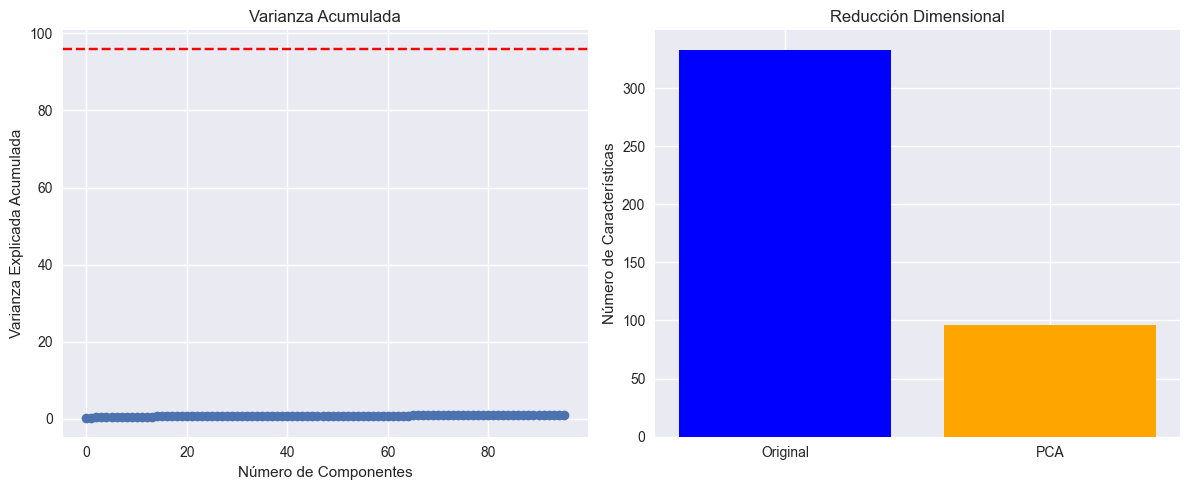

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_dimensionality_reduction(X, feature_names, config, n_components=0.95):
    """Versión corregida de reducción dimensional con PCA"""
    
    print("\n🔍 Iniciando reducción dimensional con PCA")
    
    # 1. Estandarización
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # 3. Análisis de resultados
    n_components = pca.n_components_
    variance = np.cumsum(pca.explained_variance_ratio_)[-1]
    
    print(f"✓ PCA completado:")
    print(f"- Componentes seleccionados: {n_components}")
    print(f"- Varianza explicada: {variance:.2%}")
    
    # 4. Visualización
    plt.figure(figsize=(12, 5))
    
    # Varianza explicada
    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
    plt.axhline(y=n_components, color='r', linestyle='--')
    plt.title('Varianza Acumulada')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    
    # Comparación dimensional
    plt.subplot(1, 2, 2)
    plt.bar(['Original', 'PCA'], [X.shape[1], n_components], color=['blue', 'orange'])
    plt.title('Reducción Dimensional')
    plt.ylabel('Número de Características')
    
    plt.tight_layout()
    
    # Guardar resultados
    pca_path = os.path.join(config['paths']['output_folder'], 'pca_results.pkl')
    pd.to_pickle({
        'X_pca': X_pca,
        'model': pca,
        'scaler': scaler,
        'feature_names': [f'PC{i+1}' for i in range(n_components)]
    }, pca_path)
    print(f"💾 Resultados PCA guardados en: {pca_path}")
    
    return X_pca, pca

# Uso:
X_pca, pca_model = perform_dimensionality_reduction(
    X=X_mm,
    feature_names=mm_features,
    config=CONFIG,
    n_components=0.95
)

## 7. Reducción Dimensional, Selección de Características y División de Datos para Modelado Predictivo


In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

def feature_selection_and_split(X, y, feature_names, config):
    """Versión corregida para selección y división de datos"""
    
    # 1. Verificación inicial
    if y is None:
        raise ValueError("Se requieren etiquetas para selección supervisada")
    
    if len(y) != X.shape[0]:
        raise ValueError("Número de muestras en X e y no coinciden")
    
    # 2. Selección de características (KBest)
    print("\n🔍 Seleccionando características con SelectKBest...")
    k = min(50, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    # Obtener nombres de características seleccionadas
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    
    print(f"✓ Seleccionadas {k} características:")
    print(selected_features[:5], "...")  # Mostrar primeras 5
    
    # 3. División de datos
    print("\n📊 Dividiendo datos en train/val/test...")
    
    # Obtener random_state de config si existe, si no usar 42 por defecto
    random_state = 42
    if 'data_params' in config and 'random_state' in config['data_params']:
        random_state = config['data_params']['random_state']

    # Primero en train+val (80%) y test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_selected, y,
        test_size=0.2,
        random_state=random_state,
        stratify=y
    )
    
    # Luego dividir train_val en train (85%) y val (15%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.15,
        random_state=random_state,
        stratify=y_train_val
    )
    
    print("✅ División completada:")
    print(f"- Train: {X_train.shape[0]} muestras")
    print(f"- Val: {X_val.shape[0]} muestras")
    print(f"- Test: {X_test.shape[0]} muestras")
    
    # 4. Guardar resultados
    output_path = os.path.join(config['paths']['output_folder'], 'final_datasets.pkl')
    pd.to_pickle({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'selected_features': selected_features,
        'feature_selector': selector
    }, output_path)
    print(f"💾 Datasets finales guardados en: {output_path}")
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'selected_features': selected_features
    }

# Uso:
data_splits = feature_selection_and_split(
    X=X_pca,
    y=y_mm,
    feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    config=CONFIG
)


🔍 Seleccionando características con SelectKBest...
✓ Seleccionadas 50 características:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5'] ...

📊 Dividiendo datos en train/val/test...
✅ División completada:
- Train: 1562 muestras
- Val: 276 muestras
- Test: 460 muestras
💾 Datasets finales guardados en: C:\Users\torre\Downloads\PAD_UFES_Extractor\resultados\final_datasets.pkl


## 9. Entrenamiento de modelos individuales

In [11]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, ConfusionMatrixDisplay,
                           classification_report, RocCurveDisplay)
from sklearn.tree import export_text
from joblib import dump

class ModelTrainer:
    def __init__(self, config=None):
        """Inicializa el entrenador de modelos con configuración"""
        self.default_config = {
            'data_params': {
                'random_state': 42,
                'test_size': 0.2,
                'val_size': 0.15,
                'cv_folds': 5
            },
            'paths': {
                'models_folder': './models',
                'output_folder': './results',
                'plots_folder': './plots'
            },
            'model_params': {
                'n_iter_search': 20,
                'scoring': 'f1_weighted'
            }
        }
        self.config = self._merge_configs(config)
        self._create_directories()
        
    def _merge_configs(self, config):
        """Combina configuraciones por defecto con las proporcionadas"""
        if config is None:
            return self.default_config
        
        merged_config = {
            'data_params': {**self.default_config['data_params'], **config.get('data_params', {})},
            'paths': {**self.default_config['paths'], **config.get('paths', {})},
            'model_params': {**self.default_config['model_params'], **config.get('model_params', {})}
        }
        return merged_config
    
    def _create_directories(self):
        """Crea los directorios necesarios"""
        for folder in ['models_folder', 'output_folder', 'plots_folder']:
            os.makedirs(self.config['paths'][folder], exist_ok=True)
    
    def _get_model_config(self):
        """Configuración detallada de los modelos a entrenar con sintaxis correcta para pipelines"""
        random_state = self.config['data_params']['random_state']
        
        return {
            'SVM': {
                'model': SVC(probability=True, random_state=random_state),
                'params': {
                    'model__kernel': ['linear', 'rbf', 'poly'],
                    'model__C': np.logspace(-3, 2, 10),
                    'model__gamma': np.logspace(-4, 0, 5).tolist() + ['scale', 'auto'],
                    'model__degree': [2, 3, 4],
                    'model__class_weight': ['balanced', None],
                    'model__shrinking': [True, False],
                    'model__tol': [1e-4, 1e-3, 1e-2],
                    'model__cache_size': [200, 500, 1000]
                },
                'preprocessor': None,
                'balance': True
            },
            'Random_Forest': {
                'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
                'params': {
                    'model__n_estimators': [50, 100, 200, 300],
                    'model__max_depth': [None, 10, 20, 30, 50],
                    'model__min_samples_split': [2, 5, 10, 20],
                    'model__min_samples_leaf': [1, 2, 4],
                    'model__max_features': ['sqrt', 'log2', None],
                    'model__class_weight': ['balanced', 'balanced_subsample', None],
                    'model__max_leaf_nodes': [None, 10, 20, 50, 100],
                    'model__ccp_alpha': np.logspace(-4, -1, 4)
                },
                'preprocessor': None,
                'balance': True
            },
            'Decision_Tree': {
                'model': DecisionTreeClassifier(random_state=random_state),
                'params': {
                    'model__max_depth': [None, 5, 10, 15, 20, 30],
                    'model__min_samples_split': [2, 5, 10, 20],
                    'model__min_samples_leaf': [1, 2, 4, 8],
                    'model__max_features': ['sqrt', 'log2', None] + list(np.round(np.linspace(0.1, 1.0, 10), 2)),
                    'model__criterion': ['gini', 'entropy'],
                    'model__splitter': ['best', 'random'],
                    'model__class_weight': ['balanced', None]
                },
                'preprocessor': None,
                'balance': True
            }
        }
    
    def _create_pipeline(self, model_config):
        """Crea pipeline con balanceo y preprocesamiento"""
        steps = []
        
        # Añadir balanceo si hay desequilibrio
        if model_config.get('balance', True):
            steps.extend([
                ('oversampler', SMOTE(random_state=self.config['data_params']['random_state'], 
                                    sampling_strategy='minority')),
                ('undersampler', RandomUnderSampler(random_state=self.config['data_params']['random_state'], 
                                                  sampling_strategy='majority'))
            ])
        
        # Añadir preprocesador si está definido
        if model_config.get('preprocessor'):
            steps.append(('preprocessor', model_config['preprocessor']))
        
        # Añadir el modelo final
        steps.append(('model', model_config['model']))
        
        return ImbPipeline(steps)
    
    def train_models(self, X_train, y_train, X_val, y_val):
        """Entrena múltiples modelos con validación y guarda resultados"""
        # Validación de inputs
        self._validate_inputs(X_train, y_train, X_val, y_val)
        
        # Configuración
        model_configs = self._get_model_config()
        cv = StratifiedKFold(n_splits=self.config['data_params']['cv_folds'],
                            shuffle=True,
                            random_state=self.config['data_params']['random_state'])
        
        # Resultados
        trained_models = {}
        training_results = {}
        
        print("\n" + "="*60)
        print("ENTRENAMIENTO DE MODELOS - INICIO")
        print(f"- Muestras entrenamiento: {X_train.shape[0]}")
        print(f"- Muestras validación: {X_val.shape[0]}")
        print(f"- Características: {X_train.shape[1]}")
        print(f"- Semilla aleatoria: {self.config['data_params']['random_state']}")
        print("="*60)
        
        for model_name, model_info in model_configs.items():
            try:
                print(f"\n🔍 Procesando modelo: {model_name}")
                start_time = time.time()
                
                # Crear pipeline
                pipeline = self._create_pipeline(model_info)
                
                # Búsqueda de hiperparámetros
                search = RandomizedSearchCV(
                    estimator=pipeline,
                    param_distributions=model_info['params'],
                    n_iter=self.config['model_params']['n_iter_search'],
                    cv=cv,
                    scoring=self.config['model_params']['scoring'],
                    n_jobs=-1,
                    verbose=1,
                    random_state=self.config['data_params']['random_state'],
                    error_score='raise'
                )
                
                # Entrenamiento
                search.fit(X_train, y_train)
                
                # Evaluación
                best_model = search.best_estimator_
                y_val_pred = best_model.predict(X_val)
                y_val_proba = best_model.predict_proba(X_val) if hasattr(best_model, 'predict_proba') else None
                
                # Métricas
                metrics = self._calculate_metrics(y_val, y_val_pred, y_val_proba)
                performance = self._measure_performance(best_model, X_val, start_time)
                
                # Guardar resultados
                trained_models[model_name] = best_model
                training_results[model_name] = {
                    'best_params': search.best_params_,
                    'best_cv_score': search.best_score_,
                    'validation_metrics': metrics,
                    'performance': performance,
                    'predictions': {
                        'y_val_pred': y_val_pred,
                        'y_val_proba': y_val_proba
                    }
                }
                
                # Visualizaciones
                self._generate_visualizations(model_name, best_model, X_val, y_val, y_val_pred)
                
                print(f"✅ {model_name} entrenado exitosamente")
                print(f"   - F1-score (CV): {search.best_score_:.4f}")
                print(f"   - F1-score (Val): {metrics['f1']:.4f}")
                print(f"   - Tiempo total: {performance['training_time']:.2f}s")
                
            except Exception as e:
                print(f"⚠️ Error entrenando {model_name}: {str(e)}")
                training_results[model_name] = {
                    'error': str(e),
                    'status': 'failed'
                }
        
        # Guardar y reportar
        self._save_results(trained_models, training_results)
        self._generate_final_report(training_results)
        
        return trained_models, training_results
    
    def _validate_inputs(self, X_train, y_train, X_val, y_val):
        """Valida las entradas antes del entrenamiento"""
        if not isinstance(X_train, (np.ndarray, pd.DataFrame)) or len(X_train.shape) != 2:
            raise ValueError("X_train debe ser un array 2D (n_samples, n_features)")
        
        if not isinstance(y_train, (np.ndarray, pd.Series)) or len(y_train.shape) != 1:
            raise ValueError("y_train debe ser un array 1D (n_samples,)")
        
        if X_train.shape[0] != y_train.shape[0]:
            raise ValueError(f"Número de muestras inconsistente: X_train {X_train.shape[0]} vs y_train {y_train.shape[0]}")
    
    def _calculate_metrics(self, y_true, y_pred, y_proba=None):
        """Calcula múltiples métricas de evaluación"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_recall_fscore_support(y_true, y_pred, average='weighted')[0],
            'recall': precision_recall_fscore_support(y_true, y_pred, average='weighted')[1],
            'f1': precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
        }
        
        if y_proba is not None and len(np.unique(y_true)) == 2:
            try:
                from sklearn.metrics import roc_auc_score
                metrics['roc_auc'] = roc_auc_score(y_true, y_proba[:, 1])
            except Exception as e:
                print(f"⚠️ No se pudo calcular ROC AUC: {e}")
        
        return metrics
    
    def _measure_performance(self, model, X_val, start_time):
        """Mide tiempos de entrenamiento e inferencia"""
        training_time = time.time() - start_time
        
        # Medir tiempo de inferencia
        inference_start = time.time()
        _ = model.predict(X_val[:100])  # Muestra más grande para mejor estimación
        inference_time = (time.time() - inference_start) / 100
        
        return {
            'training_time': training_time,
            'inference_time': inference_time,
            'model_size': len(pickle.dumps(model))
        }
    
    def _generate_visualizations(self, model_name, model, X_val, y_val, y_pred):
        """Genera visualizaciones para el modelo"""
        plots_path = self.config['paths']['plots_folder']
        
        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.savefig(os.path.join(plots_path, f'confusion_matrix_{model_name}.png'))
        plt.close()
        
        # Reporte de clasificación
        report = classification_report(y_val, y_pred)
        with open(os.path.join(plots_path, f'classification_report_{model_name}.txt'), 'w') as f:
            f.write(report)
        
        # Curva ROC (para clasificación binaria)
        if hasattr(model, "predict_proba") and len(np.unique(y_val)) == 2:
            plt.figure(figsize=(8, 6))
            RocCurveDisplay.from_estimator(model, X_val, y_val)
            plt.title(f'Curva ROC - {model_name}')
            plt.savefig(os.path.join(plots_path, f'roc_curve_{model_name}.png'))
            plt.close()
        
        # Importancia de características (para modelos tree-based)
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:20]  # Top 20
            
            plt.figure(figsize=(10, 6))
            plt.barh(range(len(indices)), importances[indices][::-1], align='center')
            plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices][::-1])
            plt.xlabel('Importancia')
            plt.title(f'Top 20 Características - {model_name}')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_path, f'feature_importance_{model_name}.png'))
            plt.close()
    
    def _save_results(self, trained_models, training_results):
        """Guarda modelos y resultados en disco"""
        try:
            # Guardar modelos con joblib (mejor para sklearn)
            for model_name, model in trained_models.items():
                dump(model, os.path.join(self.config['paths']['models_folder'], f'{model_name}.joblib'))
            
            # Guardar resultados
            results_path = os.path.join(self.config['paths']['output_folder'], 'training_results.pkl')
            pd.to_pickle(training_results, results_path)
            
            print("\n💾 Resultados guardados:")
            print(f"- Modelos: {self.config['paths']['models_folder']}")
            print(f"- Resultados: {results_path}")
        except Exception as e:
            print(f"⚠️ Error guardando resultados: {str(e)}")
    
    def _generate_final_report(self, training_results):
        """Genera un reporte final resumido"""
        print("\n" + "="*60)
        print("REPORTE FINAL DE ENTRENAMIENTO")
        
        for model_name, results in training_results.items():
            if 'error' not in results:
                print(f"\n📊 {model_name}:")
                print(f"   - F1-score (Val): {results['validation_metrics']['f1']:.4f}")
                print(f"   - Precisión: {results['validation_metrics']['precision']:.4f}")
                print(f"   - Recall: {results['validation_metrics']['recall']:.4f}")
                print(f"   - Tiempo entrenamiento: {results['performance']['training_time']:.2f}s")
            else:
                print(f"\n❌ {model_name}: Falló - {results['error']}")
        
        print("="*60)


# Uso del código
if __name__ == "__main__":
    # Ejemplo de configuración (puede ser parcial)
    custom_config = {
        'data_params': {
            'random_state': 42,
            'cv_folds': 5
        },
        'paths': {
            'models_folder': './trained_models',
            'output_folder': './training_results',
            'plots_folder': './training_plots'
        }
    }
    
    # Inicializar el entrenador
    trainer = ModelTrainer(config=custom_config)
    
    # Ejecutar entrenamiento (usando tus datos)
    trained_models, results = trainer.train_models(
        X_train=data_splits['X_train'],
        y_train=data_splits['y_train'],
        X_val=data_splits['X_val'],
        y_val=data_splits['y_val']
    )


ENTRENAMIENTO DE MODELOS - INICIO
- Muestras entrenamiento: 1562
- Muestras validación: 276
- Características: 50
- Semilla aleatoria: 42

🔍 Procesando modelo: SVM
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ SVM entrenado exitosamente
   - F1-score (CV): 0.6649
   - F1-score (Val): 0.6331
   - Tiempo total: 132.89s

🔍 Procesando modelo: Random_Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Random_Forest entrenado exitosamente
   - F1-score (CV): 0.6002
   - F1-score (Val): 0.5703
   - Tiempo total: 52.95s

🔍 Procesando modelo: Decision_Tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Decision_Tree entrenado exitosamente
   - F1-score (CV): 0.4038
   - F1-score (Val): 0.3880
   - Tiempo total: 0.79s

💾 Resultados guardados:
- Modelos: ./trained_models
- Resultados: ./training_results\training_results.pkl

REPORTE FINAL DE ENTRENAMIENTO

📊 SVM:
   - F1-score (Val): 0.6331
   - Precisión: 0.6818
   - Recall: 0.6159
   - Tiem

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

## 10. Implementación de Ensemble Learning

In [12]:
%pip install xgboost lightgbm catboost

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 1.8/102.4 MB 15.7 MB/s eta 0:00:07
   -- ------------------------------------- 5.5/102.4 MB 17.3 MB/s eta 0:00:06
   --- ------------------------------------ 10.2/102.4 MB 19.8 MB/s eta 0:00:05
   ------ --------------------------------- 16.0/102.4 MB 22.2 MB/s eta 0:00:04
   -------- ------------------------------- 22.5/102.4 MB 24.3 MB/s eta 0:00:04
   ----------- ---------------------------- 30.4/102.4 MB 26.9 MB/s eta 0:00:03
   --------------- ------------------------ 38.8/102.4 MB 29.1 MB/s eta 0:00:03
   ------------------ --------------------- 4

In [13]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    VotingClassifier, 
    StackingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def create_ensemble_models(trained_models, X_train, y_train, X_val, y_val, random_state=42, 
                          models_folder='./ensemble_models', output_folder='./ensemble_results'):
    """
    Versión autónoma para crear modelos de ensemble con múltiples métodos avanzados
    
    Args:
        trained_models (dict): Modelos individuales entrenados
        X_train (array-like): Datos de entrenamiento
        y_train (array-like): Etiquetas de entrenamiento
        X_val (array-like): Datos de validación
        y_val (array-like): Etiquetas de validación
        random_state (int): Semilla aleatoria (default: 42)
        models_folder (str): Ruta para guardar modelos (default: './ensemble_models')
        output_folder (str): Ruta para guardar resultados (default: './ensemble_results')
    
    Returns:
        tuple: (ensemble_models, ensemble_results)
    """
    
    # ===== VALIDACIÓN DE ENTRADAS =====
    if not trained_models or not isinstance(trained_models, dict):
        raise ValueError("trained_models debe ser un diccionario no vacío")
    
    if len(X_train) != len(y_train):
        raise ValueError("X_train e y_train deben tener el mismo número de muestras")
    
    if len(X_val) != len(y_val):
        raise ValueError("X_val e y_val deben tener el mismo número de muestras")
    
    # ===== PREPARACIÓN DE DIRECTORIOS =====
    os.makedirs(models_folder, exist_ok=True)
    os.makedirs(output_folder, exist_ok=True)
    
    # ===== CONFIGURACIÓN DE MODELOS ENSEMBLE =====
    estimators = [(name, model) for name, model in trained_models.items()]
    
    ensemble_configs = {
        # Ensemble Básicos
        'Voting_Hard': {
            'model': VotingClassifier(
                estimators=estimators,
                voting='hard',
                n_jobs=-1
            ),
            'description': 'Voting Classifier con estrategia hard'
        },
        'Voting_Soft': {
            'model': VotingClassifier(
                estimators=estimators,
                voting='soft',
                n_jobs=-1
            ),
            'description': 'Voting Classifier con estrategia soft'
        },
        'Stacking_LR': {
            'model': StackingClassifier(
                estimators=estimators,
                final_estimator=LogisticRegression(
                    max_iter=1000,
                    random_state=random_state,
                    n_jobs=-1
                ),
                cv=5,
                n_jobs=-1
            ),
            'description': 'Stacking con Logistic Regression como meta-modelo'
        },
        
        # Ensemble Avanzados
        'Stacking_XGB': {
            'model': StackingClassifier(
                estimators=estimators,
                final_estimator=XGBClassifier(
                    random_state=random_state,
                    n_jobs=-1,
                    eval_metric='mlogloss',
                    use_label_encoder=False
                ),
                cv=5,
                n_jobs=-1
            ),
            'description': 'Stacking con XGBoost como meta-modelo'
        },
        'Bagging_RF': {
            'model': BaggingClassifier(
                estimator=RandomForestClassifier(
                    n_estimators=100,
                    random_state=random_state
                ),
                n_estimators=10,
                random_state=random_state,
                n_jobs=-1
            ),
            'description': 'Bagging con Random Forest como base'
        },
        
        # Boosting Algorithms
        'XGBoost': {
            'model': XGBClassifier(
                random_state=42,
                n_estimators=1000,
                learning_rate=0.01,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                n_jobs=-1,
                eval_metric='mlogloss',
                use_label_encoder=False
            ),
            'description': 'XGBoost Classifier'
        },
        'LightGBM': {
            'model': LGBMClassifier(
                random_state=42,
                n_estimators=1000,  # Aumentar significativamente
                learning_rate=0.01,  # Reducir learning rate
                max_depth=6,         # Profundidad moderada
                subsample=0.8,       # Prevenir overfitting
                n_jobs=-1
            ),
            'description': 'LightGBM Classifier'
        },
        'CatBoost': {
            'model': CatBoostClassifier(
                random_state=random_state,
                n_estimators=1000,  # Aumentar significativamente
                learning_rate=0.01,  # Reducir learning rate
                max_depth=6,         # Profundidad moderada
                subsample=0.8,       # Prevenir overfitting
                verbose=0
            ),
            'description': 'CatBoost Classifier'
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(
                random_state=42,
                n_estimators=1000,  # Aumentar iteraciones
                learning_rate=0.05, # Reducir learning rate
                max_depth=5 # Profundidad moderada
            ),
            'description': 'Gradient Boosting Classifier'
        }
    }
    
    # ===== ENTRENAMIENTO DE ENSEMBLES =====
    ensemble_models = {}
    ensemble_results = {}
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO DE MODELOS ENSEMBLE")
    print(f"- Modelos base disponibles: {len(trained_models)}")
    print(f"- Muestras entrenamiento: {X_train.shape[0]}")
    print(f"- Muestras validación: {X_val.shape[0]}")
    print(f"- Semilla aleatoria: {random_state}")
    print("="*60)
    
    for ensemble_name, config in ensemble_configs.items():
        try:
            print(f"\n🔍 Entrenando {ensemble_name}: {config['description']}")
            model = config['model']
            
            # Entrenamiento con medición de tiempo
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Evaluación
            start_time = time.time()
            y_val_pred = model.predict(X_val)
            inference_time = time.time() - start_time
            
            # Probabilidades (si aplica)
            y_val_proba = model.predict_proba(X_val) if hasattr(model, 'predict_proba') else None
            
            # Cálculo de métricas
            accuracy = accuracy_score(y_val, y_val_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_val, y_val_pred, average='weighted', zero_division=0
            )
            
            # Almacenamiento de resultados
            ensemble_models[ensemble_name] = model
            ensemble_results[ensemble_name] = {
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                },
                'performance': {
                    'training_time': training_time,
                    'inference_time': inference_time,
                    'model_size': len(pickle.dumps(model))
                },
                'predictions': {
                    'y_val_pred': y_val_pred,
                    'y_val_proba': y_val_proba
                }
            }
            
            print(f"✅ {ensemble_name} entrenado exitosamente")
            print(f"   - F1-score: {f1:.4f}")
            print(f"   - Accuracy: {accuracy:.4f}")
            print(f"   - Tiempo entrenamiento: {training_time:.2f}s")
            
        except Exception as e:
            print(f"⚠️ Error entrenando {ensemble_name}: {str(e)}")
            ensemble_results[ensemble_name] = {
                'error': str(e),
                'status': 'failed'
            }
    
    # ===== GUARDADO DE RESULTADOS =====
    try:
        models_path = os.path.join(models_folder, 'ensemble_models.pkl')
        results_path = os.path.join(output_folder, 'ensemble_results.pkl')
        
        pd.to_pickle(ensemble_models, models_path)
        pd.to_pickle(ensemble_results, results_path)
        
        print("\n💾 Modelos y resultados guardados:")
        print(f"- Modelos: {models_path}")
        print(f"- Resultados: {results_path}")
    except Exception as e:
        print(f"⚠️ Error guardando resultados: {str(e)}")
    
    # ===== REPORTE FINAL =====
    print("\n" + "="*60)
    print("RESUMEN FINAL DE MODELOS ENSEMBLE")
    print("="*60)
    
    # Crear DataFrame con resultados
    results_list = []
    for name, res in ensemble_results.items():
        if 'metrics' in res:
            results_list.append({
                'Modelo': name,
                'F1-score': res['metrics']['f1'],
                'Accuracy': res['metrics']['accuracy'],
                'Tiempo (s)': res['performance']['training_time'],
                'Estado': 'Éxito'
            })
        else:
            results_list.append({
                'Modelo': name,
                'F1-score': np.nan,
                'Accuracy': np.nan,
                'Tiempo (s)': np.nan,
                'Estado': 'Falló'
            })
    
    results_df = pd.DataFrame(results_list).sort_values('F1-score', ascending=False)
    print("\n📊 Comparación de Modelos:")
    print(results_df.to_string(index=False))
    
    return ensemble_models, ensemble_results

# Ejemplo de uso directo sin configuración externa
ensemble_models, ensemble_results = create_ensemble_models(
    trained_models=trained_models,  # Tus modelos individuales entrenados
    X_train=data_splits['X_train'],               # Datos de entrenamiento
    y_train=data_splits['y_train'],               # Etiquetas de entrenamiento
    X_val=data_splits['X_val'],                   # Datos de validación
    y_val=data_splits['y_val'],                   # Etiquetas de validación
    random_state=42,               # Semilla aleatoria (opcional)
    models_folder='./my_models',   # Carpeta para modelos (opcional)
    output_folder='./my_results'   # Carpeta para resultados (opcional)
)


ENTRENAMIENTO DE MODELOS ENSEMBLE
- Modelos base disponibles: 3
- Muestras entrenamiento: 1562
- Muestras validación: 276
- Semilla aleatoria: 42

🔍 Entrenando Voting_Hard: Voting Classifier con estrategia hard
✅ Voting_Hard entrenado exitosamente
   - F1-score: 0.5954
   - Accuracy: 0.5906
   - Tiempo entrenamiento: 0.85s

🔍 Entrenando Voting_Soft: Voting Classifier con estrategia soft
✅ Voting_Soft entrenado exitosamente
   - F1-score: 0.5417
   - Accuracy: 0.5471
   - Tiempo entrenamiento: 0.83s

🔍 Entrenando Stacking_LR: Stacking con Logistic Regression como meta-modelo
✅ Stacking_LR entrenado exitosamente
   - F1-score: 0.7135
   - Accuracy: 0.7391
   - Tiempo entrenamiento: 4.19s

🔍 Entrenando Stacking_XGB: Stacking con XGBoost como meta-modelo
✅ Stacking_XGB entrenado exitosamente
   - F1-score: 0.6595
   - Accuracy: 0.6739
   - Tiempo entrenamiento: 4.69s

🔍 Entrenando Bagging_RF: Bagging con Random Forest como base
✅ Bagging_RF entrenado exitosamente
   - F1-score: 0.6023
   